### 1. Import Bibliotek

In [1]:
# conda install -c conda-forge lightgbm

In [1]:
import pandas as pd
import numpy as np
import openml
from warnings import filterwarnings

# Data
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder

# Preprocessing
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.base import clone

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from scipy import stats
from scipy.stats import randint, uniform
from scipy.stats import friedmanchisquare

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

import ast

### 2. Wczytanie i Przygotowanie Danych

In [2]:
# Dataset 1 - ilpd
dataset = openml.datasets.get_dataset('ilpd')
X, y, _, _ = dataset.get_data(dataset_format="dataframe", target=dataset.default_target_attribute)
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123, stratify=y)
ilpd_train_data = (X_train, y_train)
ilpd_test_data  = (X_test, y_test)

In [3]:
# Dataset 2 - wdbc
dataset = openml.datasets.get_dataset('wdbc')
X, y, _, _ = dataset.get_data(dataset_format="dataframe", target=dataset.default_target_attribute)
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123, stratify=y)
wdbc_train_data = (X_train, y_train)
wdbc_test_data  = (X_test, y_test)

In [4]:
# Dataset 3 - blood-transfusion-service-center
dataset = openml.datasets.get_dataset('blood-transfusion-service-center')
X, y, _, _ = dataset.get_data(dataset_format="dataframe", target=dataset.default_target_attribute)
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123, stratify=y)
blood_transfusion_train_data = (X_train, y_train)
blood_transfusion_test_data  = (X_test, y_test)

In [5]:
# Dataset 4 - haberman
dataset = openml.datasets.get_dataset('haberman')
X, y, _, _ = dataset.get_data(dataset_format="dataframe", target=dataset.default_target_attribute)
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123, stratify=y)
haberman_train_data = (X_train, y_train)
haberman_test_data  = (X_test, y_test)

In [6]:
# Dataset 5 - heart-statlog
dataset = openml.datasets.get_dataset('heart-statlog')
X, y, _, _ = dataset.get_data(dataset_format="dataframe", target=dataset.default_target_attribute)
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123, stratify=y)
heart_statlog_train_data = (X_train, y_train)
heart_statlog_test_data  = (X_test, y_test)

In [7]:
# Dataset 6 - hepatitis
dataset = openml.datasets.get_dataset('hepatitis')
X, y, _, _ = dataset.get_data(dataset_format="dataframe", target=dataset.default_target_attribute)
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123, stratify=y)
hepatitis_train_data = (X_train, y_train)
hepatitis_test_data  = (X_test, y_test)

In [8]:
# Dataset 7 - kc2
dataset = openml.datasets.get_dataset('kc2')
X, y, _, _ = dataset.get_data(dataset_format="dataframe", target=dataset.default_target_attribute)
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123, stratify=y)
kc2_train_data = (X_train, y_train)
kc2_test_data  = (X_test, y_test)

In [9]:
# Dataset 8 - thoracic-surgery
dataset = openml.datasets.get_dataset('thoracic-surgery')
X, y, _, _ = dataset.get_data(dataset_format="dataframe", target=dataset.default_target_attribute)
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123, stratify=y)
thoracic_surgery_train_data = (X_train, y_train)
thoracic_surgery_test_data  = (X_test, y_test)

In [10]:
datasets = [
    ('wdbc', wdbc_train_data),
    ('ilpd', ilpd_train_data),
    ('blood-transfusion-service-center', blood_transfusion_train_data),
    ('haberman', haberman_train_data),
    ('heart-statlog', heart_statlog_train_data),
    ('hepatitis', hepatitis_train_data),
    ('kc2', kc2_train_data),
    ('thoracic-surgery', thoracic_surgery_train_data)
]

datasets_test = [
    ('wdbc', wdbc_test_data),
    ('ilpd', ilpd_test_data),
    ('blood-transfusion-service-center', blood_transfusion_test_data),
    ('haberman', haberman_test_data),
    ('heart-statlog', heart_statlog_test_data),
    ('hepatitis', hepatitis_test_data),
    ('kc2', kc2_test_data),
    ('thoracic-surgery', thoracic_surgery_test_data)
]

### 3. Pipeline i siatki hiperparametrów

In [12]:
### Transformacje - dla wszystkich modeli
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler',  StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    #('onehot',  OneHotEncoder(handle_unknown = 'ignore', drop='first', sparse=False))
    ('onehot',  OneHotEncoder(handle_unknown = 'ignore', drop='first', sparse_output=False))
])

column_transformer = ColumnTransformer(
    transformers = [
        ('numerical'  , numerical_transformer   , make_column_selector(dtype_include = np.number)),
        ('categorical', categorical_transformer , make_column_selector(dtype_include = object))]
)


### --- Model 1: Random Forest --- 
random_forest_pipeline = Pipeline([
    ('preprocessing', column_transformer),
    ('model', RandomForestClassifier(random_state=123)) 
])

### --- Model 2: XGBoost --- 
xgboost_pipeline = Pipeline([
    ('preprocessing', column_transformer),
    ('model', XGBClassifier(random_state=123))
])

### --- Model 3: LightGBM --- 
lightgbm_pipeline = Pipeline([
    ('preprocessing', column_transformer),
    ('model', LGBMClassifier(random_state=123)) 
])

In [13]:
# === 1. Przestrzenie parametrów dla Modelu 1 - Random Forest ===
# (Oparte na najważniejszych parametrach z artykułu Tunability)

rf_params = {
    'grid': {
        'model__max_features': [0.25, 0.5, 0.75, 1],
        'model__max_samples': [0.5, 0.8, 1.0],
        'model__n_estimators': [100, 150, 200, 250, 300]
    },
    'random': {
        'model__max_features': uniform(0.1, 0.9),      # Odpowiednik 'mtry'
        'model__max_samples': uniform(0.5, 0.5),       # Odpowiednik 'sample.fraction' (zakres 0.5 do 1.0)
        'model__n_estimators': randint(100, 300)       # Odpowiednik 'num.trees'
    },
    'bayes': {
        'model__max_features': Real(0.1, 1.0),
        'model__max_samples': Real(0.5, 1.0),
        'model__n_estimators': Integer(100, 300)
    }
}

In [14]:
# === 2. Przestrzenie parametrów dla Modelu 2 - XGBoost ===
# (Oparte na najważniejszych parametrach z artykułu Tunability)

xgb_params = {
    'grid': {
        'model__booster': ['gbtree', 'dart'],
        'model__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4],
        'model__n_estimators': [100, 150, 200, 250, 300]
    },
    'random': {
        'model__booster': ['gbtree', 'dart'],
        'model__learning_rate': uniform(0.01, 0.39),  # Odpowiednik 'eta'
        'model__n_estimators': randint(100, 300)       # Odpowiednik 'nrounds'
    },
    'bayes': {
        'model__booster': Categorical(['gbtree', 'dart']),
        'model__learning_rate': Real(0.01, 0.4, 'log-uniform'),
        'model__n_estimators': Integer(100, 300)
    }
}

In [15]:
# === 3. Przestrzenie parametrów dla Modelu 3 - LightGBM ===

lgbm_params = {
    'grid': {
        'model__num_leaves': [12, 15, 21, 31, 41, 51],
        'model__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4],
        'model__n_estimators': [100, 150, 200, 250, 300]
    },
    'random': {
        'model__num_leaves': randint(10, 60),
        'model__learning_rate': uniform(0.01, 0.39),
        'model__n_estimators': randint(100, 300)
    },
    'bayes': {
        'model__num_leaves': Integer(10, 60),
        'model__learning_rate': Real(0.01, 0.4, 'log-uniform'),
        'model__n_estimators': Integer(100, 300)
    }
}

### 4. Obliczenie hiperparametrów dla wybranego algorytmu

In [16]:
def run_hyperparameter_tuning(X_train, y_train, pipeline, param_grids, dataset_name, model_name):
    
    """
    Uruchamia Grid, Random i Bayes Search dla danego pipeline'u i danych.
    """
    results_list = []
    
    # --- Ustawienia wspólne ---
    N_ITER_RANDOM_BAYES = 125 # Liczba iteracji dla Random/Bayes
    SCORING  = 'roc_auc'
    CV_FOLDS = KFold(5, random_state=123, shuffle=True)
    
    # --- GridSearchCV ---
    grid_search = GridSearchCV(
        estimator       =  pipeline, 
        param_grid      =  param_grids['grid'],
        cv              =  CV_FOLDS,
        scoring         =  SCORING,
        n_jobs          =  -1
    )
    grid_search.fit(X_train, y_train)
    df_grid = pd.DataFrame(grid_search.cv_results_)
    # Rozwijanie parametrów dla GridSearch
    params_grid = df_grid['params'].apply(pd.Series)
    df_grid = pd.concat([df_grid, params_grid], axis=1)
    df_grid['search_method'] = 'GridSearch'
    df_grid['iteration'] = df_grid.index + 1
    results_list.append(df_grid)

    # --- RandomizedSearchCV ---
    random_search = RandomizedSearchCV(
        estimator           =   pipeline,
        param_distributions =   param_grids['random'],
        n_iter              =   N_ITER_RANDOM_BAYES,
        cv                  =   CV_FOLDS,
        scoring             =   SCORING,
        n_jobs              =   -1,
        random_state        =   42
    )
    random_search.fit(X_train, y_train)
    df_random = pd.DataFrame(random_search.cv_results_)
    # Rozwijanie parametrów dla RandomSearch
    params_random = df_random['params'].apply(pd.Series)
    df_random = pd.concat([df_random, params_random], axis=1)
    df_random['search_method'] = 'RandomSearch'
    df_random['iteration'] = df_random.index + 1
    results_list.append(df_random)

    # --- BayesSearchCV  ---
    bayes_search = BayesSearchCV(
        estimator       =   pipeline,
        search_spaces   =   param_grids['bayes'],
        n_iter          =   N_ITER_RANDOM_BAYES,
        cv              =   CV_FOLDS,
        scoring         =   SCORING,
        n_jobs          =   -1,
        random_state    =   42
    )
    bayes_search.fit(X_train, y_train)
    df_bayes = pd.DataFrame(bayes_search.cv_results_)
    # Rozwijanie parametrów dla BayesSearch
    params_bayes = df_bayes['params'].apply(pd.Series)
    df_bayes = pd.concat([df_bayes, params_bayes], axis=1)
    df_bayes['search_method'] = 'BayesSearch'
    df_bayes['iteration'] = df_bayes.index + 1
    results_list.append(df_bayes)

    # --- Połączenie wyników ---
    final_results_df = pd.concat(results_list, ignore_index=True)
    final_results_df['dataset'] = dataset_name
    final_results_df['model'] = model_name

    columns_to_keep = [
        'dataset', 'model', 'search_method', 'iteration', 
        'mean_test_score', 'std_test_score', 'rank_test_score', 'params'
        ] + [c for c in final_results_df.columns if c.startswith('model__')]
    final_columns = [col for col in columns_to_keep if col in final_results_df.columns]
    
    return final_results_df[final_columns]


In [ ]:
# Wywołanie dla RANDOM FOREST 
rf_results = []

for d_name, (X_train, y_train) in datasets:
    results_df = run_hyperparameter_tuning(
        X_train      = X_train,
        y_train      = y_train,
        pipeline     = random_forest_pipeline,   
        param_grids  = rf_params,     
        dataset_name = d_name,
        model_name   = 'RandomForest'     
        )
    rf_results.append(results_df)

In [ ]:
rf_results_dataframe = pd.concat(rf_results, ignore_index=True)
rf_results_dataframe['params'] = rf_results_dataframe['params'].apply(lambda x: dict(x) if hasattr(x, 'keys') else x)

In [ ]:
rf_results_dataframe

,dataset,model,search_method,iteration,mean_test_score,std_test_score,rank_test_score,params,model__max_features,model__max_samples,model__n_estimators
0,wdbc,RandomForest,GridSearch,1,0.991812,0.007431,29,"{'model__max_features': 0.25, 'model__max_samp...",0.250000,0.500000,100.0
1,wdbc,RandomForest,GridSearch,2,0.992372,0.006561,23,"{'model__max_features': 0.25, 'model__max_samp...",0.250000,0.500000,150.0
2,wdbc,RandomForest,GridSearch,3,0.992520,0.006839,17,"{'model__max_features': 0.25, 'model__max_samp...",0.250000,0.500000,200.0
3,wdbc,RandomForest,GridSearch,4,0.992381,0.007445,21,"{'model__max_features': 0.25, 'model__max_samp...",0.250000,0.500000,250.0
4,wdbc,RandomForest,GridSearch,5,0.992381,0.007445,21,"{'model__max_features': 0.25, 'model__max_samp...",0.250000,0.500000,300.0
...,...,...,...,...,...,...,...,...,...,...,...
2475,thoracic-surgery,RandomForest,BayesSearch,121,0.560019,0.052016,7,"{'model__max_features': 0.8015119324734489, 'm...",0.801512,0.748226,100.0
2476,thoracic-surgery,RandomForest,BayesSearch,122,0.560019,0.052016,7,"{'model__max_features': 0.8005885863307923, 'm...",0.800589,0.748229,100.0
2477,thoracic-surgery,RandomForest,BayesSearch,123,0.554899,0.046349,21,"{'model__max_features': 1.0, 'model__max_sampl...",1.000000,0.749800,127.0
2478,thoracic-surgery,RandomForest,BayesSearch,124,0.545913,0.062164,58,"{'model__max_features': 0.1, 'model__max_sampl...",0.100000,0.654964,100.0


In [ ]:
# Zapis do CSV
output_filename = 'rf_results.csv'
rf_results_dataframe.to_csv(output_filename, index=False)

In [ ]:
# Wywołanie dla XGBOOST

xgb_results = []

for d_name, (X_train, y_train) in datasets:
    results_df = run_hyperparameter_tuning(
        X_train      = X_train,
        y_train      = y_train,
        pipeline     = xgboost_pipeline,   
        param_grids  = xgb_params,     
        dataset_name = d_name,
        model_name   = 'XGBoost'     
        )
    xgb_results.append(results_df)

In [82]:
xgb_results_dataframe = pd.concat(xgb_results, ignore_index=True)
xgb_results_dataframe['params'] = xgb_results_dataframe['params'].apply(lambda x: dict(x) if hasattr(x, 'keys') else x)

In [83]:
xgb_results_dataframe

,dataset,model,search_method,iteration,mean_test_score,std_test_score,rank_test_score,params,model__booster,model__learning_rate,model__n_estimators
0,wdbc,XGBoost,GridSearch,1,0.983098,0.011968,69,"{'model__booster': 'gbtree', 'model__learning_...",gbtree,0.010000,100
1,wdbc,XGBoost,GridSearch,2,0.987246,0.010577,67,"{'model__booster': 'gbtree', 'model__learning_...",gbtree,0.010000,150
2,wdbc,XGBoost,GridSearch,3,0.987830,0.010903,65,"{'model__booster': 'gbtree', 'model__learning_...",gbtree,0.010000,200
3,wdbc,XGBoost,GridSearch,4,0.991414,0.006566,61,"{'model__booster': 'gbtree', 'model__learning_...",gbtree,0.010000,250
4,wdbc,XGBoost,GridSearch,5,0.992044,0.006211,33,"{'model__booster': 'gbtree', 'model__learning_...",gbtree,0.010000,300
...,...,...,...,...,...,...,...,...,...,...,...
2555,thoracic-surgery,XGBoost,BayesSearch,121,0.505495,0.059316,50,"{'model__booster': 'dart', 'model__learning_ra...",dart,0.177800,100
2556,thoracic-surgery,XGBoost,BayesSearch,122,0.522434,0.037029,2,"{'model__booster': 'dart', 'model__learning_ra...",dart,0.169847,100
2557,thoracic-surgery,XGBoost,BayesSearch,123,0.505898,0.049645,45,"{'model__booster': 'dart', 'model__learning_ra...",dart,0.167507,100
2558,thoracic-surgery,XGBoost,BayesSearch,124,0.507048,0.049779,40,"{'model__booster': 'dart', 'model__learning_ra...",dart,0.050943,300


In [84]:
# Zapis do CSV
output_filename = 'xgb_results.csv'
xgb_results_dataframe.to_csv(output_filename, index=False)

In [22]:
# Wywołanie dla LIGHTGBM

lgbm_results = []

for d_name, (X_train, y_train) in datasets:
    results_df = run_hyperparameter_tuning(
        X_train      = X_train,
        y_train      = y_train,
        pipeline     = lightgbm_pipeline,   
        param_grids  = lgbm_params,     
        dataset_name = d_name,
        model_name   = 'LightGBM'     
        )
    lgbm_results.append(results_df)

[LightGBM] [Info] Number of positive: 170, number of negative: 285
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4545
[LightGBM] [Info] Number of data points in the train set: 455, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.373626 -> initscore=-0.516691
[LightGBM] [Info] Start training from score -0.516691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.01, 100, 60] before, using random point [0.04500893628906543, 268, 48]
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.01, 100, 10] before, using random point [0.041953533888176194, 126, 33]
  warnings.warn(


[LightGBM] [Info] Number of positive: 98, number of negative: 26
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153
[LightGBM] [Info] Number of data points in the train set: 124, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.790323 -> initscore=1.326871
[LightGBM] [Info] Start training from score 1.326871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [79]:
lgbm_results_dataframe = pd.concat(lgbm_results, ignore_index=True)
lgbm_results_dataframe['params'] = lgbm_results_dataframe['params'].apply(lambda x: dict(x) if hasattr(x, 'keys') else x)

In [80]:
lgbm_results_dataframe

,dataset,model,search_method,iteration,mean_test_score,std_test_score,rank_test_score,params,model__learning_rate,model__n_estimators,model__num_leaves
0,wdbc,LightGBM,GridSearch,1,0.986275,0.009881,205,"{'model__learning_rate': 0.01, 'model__n_estim...",0.010000,100.0,12.0
1,wdbc,LightGBM,GridSearch,2,0.986275,0.009881,205,"{'model__learning_rate': 0.01, 'model__n_estim...",0.010000,100.0,15.0
2,wdbc,LightGBM,GridSearch,3,0.986275,0.009881,205,"{'model__learning_rate': 0.01, 'model__n_estim...",0.010000,100.0,21.0
3,wdbc,LightGBM,GridSearch,4,0.986275,0.009881,205,"{'model__learning_rate': 0.01, 'model__n_estim...",0.010000,100.0,31.0
4,wdbc,LightGBM,GridSearch,5,0.986275,0.009881,205,"{'model__learning_rate': 0.01, 'model__n_estim...",0.010000,100.0,41.0
...,...,...,...,...,...,...,...,...,...,...,...
3675,thoracic-surgery,LightGBM,BayesSearch,121,0.494527,0.041058,56,"{'model__learning_rate': 0.12689228498255223, ...",0.126892,202.0,10.0
3676,thoracic-surgery,LightGBM,BayesSearch,122,0.494682,0.045555,54,"{'model__learning_rate': 0.1254671704407289, '...",0.125467,206.0,10.0
3677,thoracic-surgery,LightGBM,BayesSearch,123,0.500776,0.042844,19,"{'model__learning_rate': 0.12464363287390165, ...",0.124644,208.0,10.0
3678,thoracic-surgery,LightGBM,BayesSearch,124,0.479867,0.051375,114,"{'model__learning_rate': 0.02282337774438095, ...",0.022823,105.0,59.0


In [81]:
# Zapis do CSV
output_filename = 'lgbm_results.csv'
lgbm_results_dataframe.to_csv(output_filename, index=False)

### * Wczytanie ramek danych

In [16]:
rf_results_dataframe = pd.read_csv('rf_results.csv', float_precision='round_trip', converters={'params': ast.literal_eval})

In [17]:
xgb_results_dataframe = pd.read_csv('xgb_results.csv', float_precision='round_trip', converters={'params': ast.literal_eval})

In [18]:
lgbm_results_dataframe = pd.read_csv('lgbm_results.csv', float_precision='round_trip', converters={'params': ast.literal_eval})

### 5. Wyznaczenie nowej domyślnej konfiguracji hiperparametrów dla rozważanych algorytmów

In [20]:
def find_new_default(expanded_df):
    """
    Znajduje nową domyślną konfigurację hiperparametrów dla metod wyszukiwania Grid i Random.
    
    Returns:
        DataFrame: DataFrame containing best parameters and scores for each search method
    """
    param_cols = [c for c in expanded_df.columns if c.startswith('model__')]
    results_list = []
    
    for method in ['GridSearch', 'RandomSearch']:
        method_df = expanded_df[expanded_df['search_method'] == method]
        
        if not method_df.empty:
            grouped_scores = (
                method_df
                .groupby(param_cols, as_index=False)['mean_test_score']
                .mean()
                .sort_values('mean_test_score', ascending=False)
            )
            best_config = grouped_scores.iloc[0]

            result_row = {
                'search_method': method,
                'mean_test_score': best_config['mean_test_score'],
                'params': {param: best_config[param] for param in param_cols}
            }
            for param in param_cols:
                result_row[param] = best_config[param]
                
            results_list.append(result_row)
    
    return pd.DataFrame(results_list)

#### Random Forest

In [21]:
new_default_params_rf = find_new_default(rf_results_dataframe)

In [22]:
new_default_params_rf

,search_method,mean_test_score,params,model__max_features,model__max_samples,model__n_estimators
0,GridSearch,0.784939,"{'model__max_features': 1.0, 'model__max_sampl...",1.000000,0.800000,150.0
1,RandomSearch,0.788200,"{'model__max_features': 0.35269512619677024, '...",0.352695,0.512158,148.0


In [23]:
new_default_params_rf_grid   = new_default_params_rf['params'].iloc[0]
new_default_params_rf_random = new_default_params_rf['params'].iloc[1]

In [24]:
# Check
new_default_params_rf_random

{'model__max_features': 0.35269512619677024,
 'model__max_samples': 0.5121579832157269,
 'model__n_estimators': 148.0}

In [25]:
rf_results_dataframe[rf_results_dataframe['params'] =={'model__max_features': 0.35269512619677024,
 'model__max_samples': 0.5121579832157269,
 'model__n_estimators': 148.0}]

,dataset,model,search_method,iteration,mean_test_score,std_test_score,rank_test_score,params,model__max_features,model__max_samples,model__n_estimators
148,wdbc,RandomForest,RandomSearch,89,0.991738,0.008664,47,"{'model__max_features': 0.35269512619677024, '...",0.352695,0.512158,148.0
458,ilpd,RandomForest,RandomSearch,89,0.722161,0.069791,4,"{'model__max_features': 0.35269512619677024, '...",0.352695,0.512158,148.0
768,blood-transfusion-service-center,RandomForest,RandomSearch,89,0.724660,0.035036,1,"{'model__max_features': 0.35269512619677024, '...",0.352695,0.512158,148.0
1078,haberman,RandomForest,RandomSearch,89,0.724415,0.092005,4,"{'model__max_features': 0.35269512619677024, '...",0.352695,0.512158,148.0
1388,heart-statlog,RandomForest,RandomSearch,89,0.898837,0.063590,15,"{'model__max_features': 0.35269512619677024, '...",0.352695,0.512158,148.0
1698,hepatitis,RandomForest,RandomSearch,89,0.843675,0.044714,18,"{'model__max_features': 0.35269512619677024, '...",0.352695,0.512158,148.0
2008,kc2,RandomForest,RandomSearch,89,0.862253,0.036698,67,"{'model__max_features': 0.35269512619677024, '...",0.352695,0.512158,148.0
2318,thoracic-surgery,RandomForest,RandomSearch,89,0.537862,0.052303,39,"{'model__max_features': 0.35269512619677024, '...",0.352695,0.512158,148.0


In [26]:
# Check
new_default_params_rf_grid

{'model__max_features': 1.0,
 'model__max_samples': 0.8,
 'model__n_estimators': 150.0}

In [27]:
rf_results_dataframe[rf_results_dataframe['params'] =={'model__max_features': 1.0,
 'model__max_samples': 0.8,
 'model__n_estimators': 150.0}]

,dataset,model,search_method,iteration,mean_test_score,std_test_score,rank_test_score,params,model__max_features,model__max_samples,model__n_estimators
51,wdbc,RandomForest,GridSearch,52,0.993434,0.005760,10,"{'model__max_features': 1, 'model__max_samples...",1.0,0.8,150.0
361,ilpd,RandomForest,GridSearch,52,0.724895,0.072344,1,"{'model__max_features': 1, 'model__max_samples...",1.0,0.8,150.0
671,blood-transfusion-service-center,RandomForest,GridSearch,52,0.718854,0.041869,15,"{'model__max_features': 1, 'model__max_samples...",1.0,0.8,150.0
981,haberman,RandomForest,GridSearch,52,0.709187,0.093852,25,"{'model__max_features': 1, 'model__max_samples...",1.0,0.8,150.0
1291,heart-statlog,RandomForest,GridSearch,52,0.900964,0.050370,5,"{'model__max_features': 1, 'model__max_samples...",1.0,0.8,150.0
1601,hepatitis,RandomForest,GridSearch,52,0.836043,0.036502,29,"{'model__max_features': 1, 'model__max_samples...",1.0,0.8,150.0
1911,kc2,RandomForest,GridSearch,52,0.863398,0.040462,32,"{'model__max_features': 1, 'model__max_samples...",1.0,0.8,150.0
2221,thoracic-surgery,RandomForest,GridSearch,52,0.532739,0.053027,21,"{'model__max_features': 1, 'model__max_samples...",1.0,0.8,150.0


#### XGBoost

In [28]:
new_default_params_xgb = find_new_default(xgb_results_dataframe)

In [29]:
new_default_params_xgb

,search_method,mean_test_score,params,model__booster,model__learning_rate,model__n_estimators
0,GridSearch,0.765516,"{'model__booster': 'dart', 'model__learning_ra...",dart,0.050000,100
1,RandomSearch,0.766916,"{'model__booster': 'gbtree', 'model__learning_...",gbtree,0.028116,150


In [30]:
new_default_params_xgb_grid   = new_default_params_xgb['params'].iloc[0]
new_default_params_xgb_random = new_default_params_xgb['params'].iloc[1]

In [31]:
# Check
new_default_params_xgb_grid

{'model__booster': 'dart',
 'model__learning_rate': 0.05,
 'model__n_estimators': 100}

In [32]:
xgb_results_dataframe[xgb_results_dataframe['params'] =={'model__booster': 'dart',
 'model__learning_rate': 0.05,
 'model__n_estimators': 100}]

,dataset,model,search_method,iteration,mean_test_score,std_test_score,rank_test_score,params,model__booster,model__learning_rate,model__n_estimators
40,wdbc,XGBoost,GridSearch,41,0.992901,0.006483,11,"{'model__booster': 'dart', 'model__learning_ra...",dart,0.05,100
360,ilpd,XGBoost,GridSearch,41,0.705767,0.072325,1,"{'model__booster': 'dart', 'model__learning_ra...",dart,0.05,100
680,blood-transfusion-service-center,XGBoost,GridSearch,41,0.701833,0.032233,1,"{'model__booster': 'dart', 'model__learning_ra...",dart,0.05,100
1000,haberman,XGBoost,GridSearch,41,0.729171,0.091386,1,"{'model__booster': 'dart', 'model__learning_ra...",dart,0.05,100
1320,heart-statlog,XGBoost,GridSearch,41,0.883850,0.046860,55,"{'model__booster': 'dart', 'model__learning_ra...",dart,0.05,100
1640,hepatitis,XGBoost,GridSearch,41,0.774268,0.064416,15,"{'model__booster': 'dart', 'model__learning_ra...",dart,0.05,100
1960,kc2,XGBoost,GridSearch,41,0.854437,0.051555,5,"{'model__booster': 'dart', 'model__learning_ra...",dart,0.05,100
2280,thoracic-surgery,XGBoost,GridSearch,41,0.481897,0.033157,69,"{'model__booster': 'dart', 'model__learning_ra...",dart,0.05,100


#### LigthGBM

In [33]:
new_default_params_lgbm = find_new_default(lgbm_results_dataframe)

In [34]:
new_default_params_lgbm

,search_method,mean_test_score,params,model__learning_rate,model__n_estimators,model__num_leaves
0,GridSearch,0.781498,"{'model__learning_rate': 0.01, 'model__n_estim...",0.010000,300.0,12.0
1,RandomSearch,0.780721,"{'model__learning_rate': 0.01549113085888294, ...",0.015491,180.0,17.0


In [35]:
new_default_params_lgbm_grid   = new_default_params_lgbm['params'].iloc[0]
new_default_params_lgbm_random = new_default_params_lgbm['params'].iloc[1]

In [36]:
# Check
new_default_params_lgbm_random

{'model__learning_rate': 0.01549113085888294,
 'model__n_estimators': 180.0,
 'model__num_leaves': 17.0}

In [37]:
lgbm_results_dataframe[lgbm_results_dataframe['params'] =={'model__learning_rate': 0.01549113085888294,
 'model__n_estimators': 180.0,
 'model__num_leaves': 17.0}]

,dataset,model,search_method,iteration,mean_test_score,std_test_score,rank_test_score,params,model__learning_rate,model__n_estimators,model__num_leaves
242,wdbc,LightGBM,RandomSearch,33,0.992205,0.007887,124,"{'model__learning_rate': 0.01549113085888294, ...",0.015491,180.0,17.0
702,ilpd,LightGBM,RandomSearch,33,0.709247,0.075173,6,"{'model__learning_rate': 0.01549113085888294, ...",0.015491,180.0,17.0
1162,blood-transfusion-service-center,LightGBM,RandomSearch,33,0.721093,0.035537,1,"{'model__learning_rate': 0.01549113085888294, ...",0.015491,180.0,17.0
1622,haberman,LightGBM,RandomSearch,33,0.754180,0.091413,7,"{'model__learning_rate': 0.01549113085888294, ...",0.015491,180.0,17.0
2082,heart-statlog,LightGBM,RandomSearch,33,0.896026,0.056986,4,"{'model__learning_rate': 0.01549113085888294, ...",0.015491,180.0,17.0
2542,hepatitis,LightGBM,RandomSearch,33,0.825065,0.030182,3,"{'model__learning_rate': 0.01549113085888294, ...",0.015491,180.0,17.0
3002,kc2,LightGBM,RandomSearch,33,0.872892,0.042968,1,"{'model__learning_rate': 0.01549113085888294, ...",0.015491,180.0,17.0
3462,thoracic-surgery,LightGBM,RandomSearch,33,0.475063,0.043044,122,"{'model__learning_rate': 0.01549113085888294, ...",0.015491,180.0,17.0


### 6. Tunowalność (CV)

In [38]:
def compute_tunability(new_default_params_df, results_df):
    """
    Oblicza tunowalność dla danego algorytmu i różnych metod wyszukiwania (GridSearch, RandomSearch i BayesSearch).
    
    Parameters:
    -----------
    new_default_params_df : DataFrame
        DataFrame z nowymi domyślnymi parametrami dla każdej metody wyszukiwania
    results_df : DataFrame
        DataFrame z wszystkimi wynikami
    
    Returns:
    --------
    DataFrame
        DataFrame zawierający tunowalność (d_j) dla każdego zbioru danych i metody wyszukiwania
    """
    tunability_results = []

    param_cols = [c for c in results_df.columns if c.startswith('model__')]

    for method in ['GridSearch', 'RandomSearch', 'BayesSearch']:
    
        method_results = results_df[results_df['search_method'] == method]

        best_per_dataset = (
            method_results
            .groupby('dataset', as_index=False)['mean_test_score']
            .max()
            .rename(columns={'mean_test_score': 'best_auc'})
        )

        default_method = 'GridSearch' if method == 'BayesSearch' else method

        default_params = (
            new_default_params_df[
                new_default_params_df['search_method'] == default_method
            ]
            .iloc[0]
        )

        if method == 'BayesSearch':
            default_results = results_df[results_df['search_method'] == 'GridSearch'].copy()
        else:
            default_results = method_results.copy()

        for p in param_cols:
            default_results = default_results[default_results[p] == default_params[p]]

        tunability = best_per_dataset.merge(
            default_results[['dataset', 'mean_test_score']],
            on='dataset',
            how='inner'
        )
        tunability['d_j'] = tunability['best_auc'] - tunability['mean_test_score']
        tunability['search_method'] = method

        tunability_results.append(
            tunability[['dataset', 'search_method', 'd_j']]
        )

    return pd.concat(tunability_results, ignore_index=True)

#### Random Forest

In [39]:
tunability_rf        = compute_tunability(new_default_params_rf, rf_results_dataframe)
tunability_rf_grid   = tunability_rf[tunability_rf['search_method'] == 'GridSearch']
tunability_rf_random = tunability_rf[tunability_rf['search_method'] == 'RandomSearch']
tunability_rf_bayes  = tunability_rf[tunability_rf['search_method'] == 'BayesSearch']

In [40]:
mean_grid = tunability_rf_grid['d_j'].mean()
sem_grid  = tunability_rf_grid['d_j'].sem()
print(f"Random Forest + Grid Search: cross-validated tunability with the optimal defaults (Tun.O-CV): mean ± sem = {mean_grid:.4f} ± {sem_grid:.4f}")

Random Forest + Grid Search: cross-validated tunability with the optimal defaults (Tun.O-CV): mean ± sem = 0.0080 ± 0.0025


In [41]:
mean_random = tunability_rf_random['d_j'].mean()
sem_random  = tunability_rf_random['d_j'].sem()
print(f"Random Forest + Random Search: cross-validated tunability with the optimal defaults (Tun.O-CV): mean ± sem = {mean_random:.4f} ± {sem_random:.4f}")

Random Forest + Random Search: cross-validated tunability with the optimal defaults (Tun.O-CV): mean ± sem = 0.0073 ± 0.0027


In [42]:
mean_bayes = tunability_rf_bayes['d_j'].mean()
sem_bayes  = tunability_rf_bayes['d_j'].sem()
print(f"Random Forest + Bayes Search: cross-validated tunability with the optimal defaults from Grid Search (Tun.O-CV): mean ± sem = {mean_bayes:.4f} ± {sem_bayes:.4f}")

Random Forest + Bayes Search: cross-validated tunability with the optimal defaults from Grid Search (Tun.O-CV): mean ± sem = 0.0137 ± 0.0035


#### XGBoost

In [43]:
tunability_xgb        = compute_tunability(new_default_params_xgb, xgb_results_dataframe)
tunability_xgb_grid   = tunability_xgb[tunability_xgb['search_method'] == 'GridSearch']
tunability_xgb_random = tunability_xgb[tunability_xgb['search_method'] == 'RandomSearch']
tunability_xgb_bayes  = tunability_xgb[tunability_xgb['search_method'] == 'BayesSearch']

In [44]:
mean_grid = tunability_xgb_grid['d_j'].mean()
sem_grid  = tunability_xgb_grid['d_j'].sem()
print(f"XGBoost + Grid Search: cross-validated tunability with the optimal defaults (Tun.O-CV): mean ± sem = {mean_grid:.4f} ± {sem_grid:.4f}")

XGBoost + Grid Search: cross-validated tunability with the optimal defaults (Tun.O-CV): mean ± sem = 0.0070 ± 0.0035


In [45]:
mean_random = tunability_xgb_random['d_j'].mean()
sem_random  = tunability_xgb_random['d_j'].sem()
print(f"XGBoost + Random Search: cross-validated tunability with the optimal defaults (Tun.O-CV): mean ± sem = {mean_random:.4f} ± {sem_random:.4f}")

XGBoost + Random Search: cross-validated tunability with the optimal defaults (Tun.O-CV): mean ± sem = 0.0068 ± 0.0025


In [46]:
mean_bayes = tunability_xgb_bayes['d_j'].mean()
sem_bayes  = tunability_xgb_bayes['d_j'].sem()
print(f"XGBoost + Bayes Search: cross-validated tunability with the optimal defaults from Grid Search (Tun.O-CV): mean ± sem = {mean_bayes:.4f} ± {sem_bayes:.4f}")

XGBoost + Bayes Search: cross-validated tunability with the optimal defaults from Grid Search (Tun.O-CV): mean ± sem = 0.0110 ± 0.0051


#### LightGBM

In [47]:
tunability_lgbm        = compute_tunability(new_default_params_lgbm, lgbm_results_dataframe)
tunability_lgbm_grid   = tunability_lgbm[tunability_lgbm['search_method'] == 'GridSearch']
tunability_lgbm_random = tunability_lgbm[tunability_lgbm['search_method'] == 'RandomSearch']
tunability_lgbm_bayes  = tunability_lgbm[tunability_lgbm['search_method'] == 'BayesSearch']

In [48]:
mean_grid = tunability_lgbm_grid['d_j'].mean()
sem_grid  = tunability_lgbm_grid['d_j'].sem()
print(f"LightGBM + Grid Search: cross-validated tunability with the optimal defaults (Tun.O-CV): mean ± sem = {mean_grid:.4f} ± {sem_grid:.4f}")

LightGBM + Grid Search: cross-validated tunability with the optimal defaults (Tun.O-CV): mean ± sem = 0.0082 ± 0.0040


In [49]:
mean_random = tunability_lgbm_random['d_j'].mean()
sem_random  = tunability_lgbm_random['d_j'].sem()
print(f"LightGBM + Random Search: cross-validated tunability with the optimal defaults (Tun.O-CV): mean ± sem = {mean_random:.4f} ± {sem_random:.4f}")

LightGBM + Random Search: cross-validated tunability with the optimal defaults (Tun.O-CV): mean ± sem = 0.0076 ± 0.0043


In [50]:
mean_bayes = tunability_lgbm_bayes['d_j'].mean()
sem_bayes  = tunability_lgbm_bayes['d_j'].sem()
print(f"LightGBM + Bayes Search: cross-validated tunability with the optimal defaults from Grid Search (Tun.O-CV): mean ± sem = {mean_bayes:.4f} ± {sem_bayes:.4f}")

LightGBM + Bayes Search: cross-validated tunability with the optimal defaults from Grid Search (Tun.O-CV): mean ± sem = 0.0111 ± 0.0037


### 7. Obliczenie tunowalności na zbiorach testowych

In [51]:
def _clean_params(params_input) -> dict:
    """Wewnętrzna funkcja do czyszczenia (str -> dict oraz float -> int dla niektórych hiperparametrów)"""
    if isinstance(params_input, str):
        params_dict = ast.literal_eval(params_input)
    elif isinstance(params_input, dict):
        params_dict = params_input.copy()
    else:
        return {}

    cleaned = params_dict 
    int_params_keys = ['model__n_estimators', 'model__num_leaves',]
    
    for key in int_params_keys:
        if key in cleaned and cleaned[key] is not None:
            if not pd.isna(cleaned[key]):
                cleaned[key] = int(cleaned[key])
            else:
                cleaned[key] = None 
    return cleaned


def calculate_auc_test(
    new_default_params: dict,                 # <- przyjmuje słownik parametrów
    best_params_per_dataset_df: pd.DataFrame, # <- przyjmuje ramkę danych
    base_pipeline
) -> pd.DataFrame:
    
    # Zakłada wczytanie globalnie zbiorów danych
    train_data_dict = dict(datasets) 
    test_data_dict = dict(datasets_test)
    results = []
    
    cleaned_new_default_params = _clean_params(new_default_params)

    # Iteracja per dataset
    for _, row in best_params_per_dataset_df.iterrows():
        dataset_name = row['dataset']
        X_train, y_train = train_data_dict[dataset_name]
        X_test, y_test = test_data_dict[dataset_name]
        
        # Pobiera najlepsze hiperparametry z kroswalidacji dla danego zbioru
        best_tuned_params_input = row['params']
        cleaned_best_tuned_params = _clean_params(best_tuned_params_input)

        # Model 1: Wbudowane domyślne
        model_builtin = clone(base_pipeline)
        model_builtin.fit(X_train, y_train)
        y_pred_builtin = model_builtin.predict_proba(X_test)[:, 1]
        auc_builtin = roc_auc_score(y_test, y_pred_builtin)

        # Model 2: Nowe domyślne
        model_new_default = clone(base_pipeline)
        model_new_default.set_params(**cleaned_new_default_params)
        model_new_default.fit(X_train, y_train)
        y_pred_new = model_new_default.predict_proba(X_test)[:, 1]
        auc_new_default = roc_auc_score(y_test, y_pred_new)

        # Model 3: Najlepsze dostrojone
        model_best = clone(base_pipeline)
        model_best.set_params(**cleaned_best_tuned_params)
        model_best.fit(X_train, y_train)
        y_pred_best = model_best.predict_proba(X_test)[:, 1]
        auc_best = roc_auc_score(y_test, y_pred_best)

        results.append({
            'dataset': dataset_name,
            'auc_builtin_default': auc_builtin,
            'auc_new_default': auc_new_default,
            'auc_best_tuned': auc_best
        })

    return pd.DataFrame(results)

### 7.1 Random Forest

#### Random Forest + GridSearch

In [52]:
# ramka danych z najlepszymi hiperparametrami dla GridSearch per zbiór danych
rf_best_params_grid = rf_results_dataframe[rf_results_dataframe['search_method']=='GridSearch'].groupby('dataset').apply(lambda df: df.loc[df['mean_test_score'].idxmax()]).reset_index(drop=True)
rf_best_params_grid = rf_best_params_grid[['dataset', 'params']]

In [147]:
rf_results_dataframe

,dataset,model,search_method,iteration,mean_test_score,std_test_score,rank_test_score,params,model__max_features,model__max_samples,model__n_estimators
0,wdbc,RandomForest,GridSearch,1,0.991812,0.007431,29,"{'model__max_features': 0.25, 'model__max_samp...",0.250000,0.500000,100.0
1,wdbc,RandomForest,GridSearch,2,0.992372,0.006561,23,"{'model__max_features': 0.25, 'model__max_samp...",0.250000,0.500000,150.0
2,wdbc,RandomForest,GridSearch,3,0.992520,0.006839,17,"{'model__max_features': 0.25, 'model__max_samp...",0.250000,0.500000,200.0
3,wdbc,RandomForest,GridSearch,4,0.992381,0.007445,21,"{'model__max_features': 0.25, 'model__max_samp...",0.250000,0.500000,250.0
4,wdbc,RandomForest,GridSearch,5,0.992381,0.007445,21,"{'model__max_features': 0.25, 'model__max_samp...",0.250000,0.500000,300.0
...,...,...,...,...,...,...,...,...,...,...,...
2475,thoracic-surgery,RandomForest,BayesSearch,121,0.560019,0.052016,7,"{'model__max_features': 0.8015119324734489, 'm...",0.801512,0.748226,100.0
2476,thoracic-surgery,RandomForest,BayesSearch,122,0.560019,0.052016,7,"{'model__max_features': 0.8005885863307923, 'm...",0.800589,0.748229,100.0
2477,thoracic-surgery,RandomForest,BayesSearch,123,0.554899,0.046349,21,"{'model__max_features': 1.0, 'model__max_sampl...",1.000000,0.749800,127.0
2478,thoracic-surgery,RandomForest,BayesSearch,124,0.545913,0.062164,58,"{'model__max_features': 0.1, 'model__max_sampl...",0.100000,0.654964,100.0


In [53]:
rf_best_params_grid

,dataset,params
0,blood-transfusion-service-center,"{'model__max_features': 0.25, 'model__max_samp..."
1,haberman,"{'model__max_features': 0.25, 'model__max_samp..."
2,heart-statlog,"{'model__max_features': 1, 'model__max_samples..."
3,hepatitis,"{'model__max_features': 0.5, 'model__max_sampl..."
4,ilpd,"{'model__max_features': 1, 'model__max_samples..."
5,kc2,"{'model__max_features': 1, 'model__max_samples..."
6,thoracic-surgery,"{'model__max_features': 0.25, 'model__max_samp..."
7,wdbc,"{'model__max_features': 1, 'model__max_samples..."


In [54]:
new_default_params_rf_grid

{'model__max_features': 1.0,
 'model__max_samples': 0.8,
 'model__n_estimators': 150.0}

In [55]:
# Obliczenie AUC na zbiorze testowym 
rf_test_results = calculate_auc_test(
    new_default_params        = new_default_params_rf_grid, 
    best_params_per_dataset_df= rf_best_params_grid, 
    base_pipeline             = random_forest_pipeline
)

In [56]:
rf_test_results

,dataset,auc_builtin_default,auc_new_default,auc_best_tuned
0,blood-transfusion-service-center,0.685551,0.703582,0.696516
1,haberman,0.557065,0.555027,0.572011
2,heart-statlog,0.915972,0.897917,0.937500
3,hepatitis,0.856667,0.833333,0.806667
4,ilpd,0.772325,0.772147,0.815025
5,kc2,0.771906,0.756846,0.776287
6,thoracic-surgery,0.613839,0.650893,0.619643
7,wdbc,0.990575,0.990245,0.988757


In [57]:
rf_test_results['dj_P'] = rf_test_results['auc_best_tuned'] - rf_test_results['auc_builtin_default']
rf_test_results['dj_O'] = rf_test_results['auc_best_tuned'] - rf_test_results['auc_new_default']

In [58]:
rf_test_results

,dataset,auc_builtin_default,auc_new_default,auc_best_tuned,dj_P,dj_O
0,blood-transfusion-service-center,0.685551,0.703582,0.696516,0.010965,-0.007066
1,haberman,0.557065,0.555027,0.572011,0.014946,0.016984
2,heart-statlog,0.915972,0.897917,0.937500,0.021528,0.039583
3,hepatitis,0.856667,0.833333,0.806667,-0.050000,-0.026667
4,ilpd,0.772325,0.772147,0.815025,0.042700,0.042877
5,kc2,0.771906,0.756846,0.776287,0.004381,0.019441
6,thoracic-surgery,0.613839,0.650893,0.619643,0.005804,-0.031250
7,wdbc,0.990575,0.990245,0.988757,-0.001819,-0.001488


In [59]:
mean_grid_P = rf_test_results['dj_P'].mean()
sem_grid_P  = rf_test_results['dj_P'].sem()
print(f"Random Forest + Grid Search: tunability with the package defaults (Tun. P): mean ± sem = {mean_grid_P:.4f} ± {sem_grid_P:.4f}")

Random Forest + Grid Search: tunability with the package defaults (Tun. P): mean ± sem = 0.0061 ± 0.0093


In [60]:
mean_grid_O = rf_test_results['dj_O'].mean()
sem_grid_O  = rf_test_results['dj_O'].sem()
print(f"Random Forest + Grid Search: tunability with the optimal defaults (Tun. O): mean ± sem = {mean_grid_O:.4f} ± {sem_grid_O:.4f}")

Random Forest + Grid Search: tunability with the optimal defaults (Tun. O): mean ± sem = 0.0066 ± 0.0099


In [61]:
improv = mean_grid_P - mean_grid_O
sem_grid_improv = (rf_test_results['dj_P'] - rf_test_results['dj_O']).sem()
print(f"Improvement (Tun.P - Tun.0)= {improv:.4f} ± {sem_grid_improv:.4f}")

Improvement (Tun.P - Tun.0)= -0.0005 ± 0.0071


In [62]:
rf_test_results_grid = rf_test_results.copy()
rf_test_results_grid['search_method'] = 'GridSearch'

#### Random Forest + Random Search

In [63]:
# ramka danych z najlepszymi hiperparametrami dla GridSearch per zbiór danych
rf_best_params_random = rf_results_dataframe[rf_results_dataframe['search_method']=='RandomSearch'].groupby('dataset').apply(lambda df: df.loc[df['mean_test_score'].idxmax()]).reset_index(drop=True)
rf_best_params_random = rf_best_params_random[['dataset', 'params']]

In [64]:
rf_best_params_random

,dataset,params
0,blood-transfusion-service-center,"{'model__max_features': 0.35269512619677024, '..."
1,haberman,"{'model__max_features': 0.1274502249451445, 'm..."
2,heart-statlog,"{'model__max_features': 0.12828626711806082, '..."
3,hepatitis,"{'model__max_features': 0.602291801815607, 'mo..."
4,ilpd,"{'model__max_features': 0.19980173873064822, '..."
5,kc2,"{'model__max_features': 0.602291801815607, 'mo..."
6,thoracic-surgery,"{'model__max_features': 0.5104629857953323, 'm..."
7,wdbc,"{'model__max_features': 0.1274502249451445, 'm..."


In [65]:
new_default_params_rf_random

{'model__max_features': 0.35269512619677024,
 'model__max_samples': 0.5121579832157269,
 'model__n_estimators': 148.0}

In [66]:
# Obliczenie AUC na zbiorze tesotwym 
rf_test_results = calculate_auc_test(
    new_default_params        = new_default_params_rf_random, 
    best_params_per_dataset_df= rf_best_params_random, 
    base_pipeline             = random_forest_pipeline
)

In [67]:
rf_test_results['dj_P'] = rf_test_results['auc_best_tuned'] - rf_test_results['auc_builtin_default']
rf_test_results['dj_O'] = rf_test_results['auc_best_tuned'] - rf_test_results['auc_new_default']

In [68]:
rf_test_results

,dataset,auc_builtin_default,auc_new_default,auc_best_tuned,dj_P,dj_O
0,blood-transfusion-service-center,0.685551,0.689693,0.689693,0.004142,0.000000
1,haberman,0.557065,0.561821,0.561141,0.004076,-0.000679
2,heart-statlog,0.915972,0.915972,0.918750,0.002778,0.002778
3,hepatitis,0.856667,0.843333,0.856667,0.000000,0.013333
4,ilpd,0.772325,0.798724,0.796775,0.024451,-0.001949
5,kc2,0.771906,0.768894,0.771632,-0.000274,0.002738
6,thoracic-surgery,0.613839,0.636161,0.649107,0.035268,0.012946
7,wdbc,0.990575,0.991071,0.989253,-0.001323,-0.001819


In [69]:
mean_grid_P = rf_test_results['dj_P'].mean()
sem_grid_P  = rf_test_results['dj_P'].sem()
print(f"Random Forest + Random Search: tunability with the package defaults (Tun. P): mean ± sem = {mean_grid_P:.4f} ± {sem_grid_P:.4f}")

Random Forest + Random Search: tunability with the package defaults (Tun. P): mean ± sem = 0.0086 ± 0.0048


In [70]:
mean_grid_O = rf_test_results['dj_O'].mean()
sem_grid_O  = rf_test_results['dj_O'].sem()
print(f"Random Forest + Random Search: tunability with the optimal defaults (Tun. O): mean ± sem = {mean_grid_O:.4f} ± {sem_grid_O:.4f}")

Random Forest + Random Search: tunability with the optimal defaults (Tun. O): mean ± sem = 0.0034 ± 0.0022


In [71]:
improv = mean_grid_P - mean_grid_O
sem_grid_improv = (rf_test_results['dj_P'] - rf_test_results['dj_O']).sem()
print(f"Improvement (Tun.P - Tun.0)= {improv:.4f} ± {sem_grid_improv:.4f}")

Improvement (Tun.P - Tun.0)= 0.0052 ± 0.0046


In [72]:
rf_test_results_random = rf_test_results.copy()
rf_test_results_random['search_method'] = 'RandomSearch'

#### Random Forest + Bayes Search

In [148]:
# ramka danych z najlepszymi hiperparametrami dla BayesSearch per zbiór danych
rf_best_params_bayes = rf_results_dataframe[rf_results_dataframe['search_method']=='BayesSearch'].groupby('dataset').apply(lambda df: df.loc[df['mean_test_score'].idxmax()]).reset_index(drop=True)
rf_best_params_bayes = rf_best_params_bayes[['dataset', 'params']]

In [149]:
rf_best_params_bayes

,dataset,params
0,blood-transfusion-service-center,"{'model__max_features': 0.43150563792202556, '..."
1,haberman,"{'model__max_features': 0.9914562305723162, 'm..."
2,heart-statlog,"{'model__max_features': 0.1, 'model__max_sampl..."
3,hepatitis,"{'model__max_features': 0.6011466823973818, 'm..."
4,ilpd,"{'model__max_features': 0.10037024500208624, '..."
5,kc2,"{'model__max_features': 0.6349664208502716, 'm..."
6,thoracic-surgery,"{'model__max_features': 0.8060605690962924, 'm..."
7,wdbc,"{'model__max_features': 0.1, 'model__max_sampl..."


In [150]:
new_default_params_rf_grid

{'model__max_features': 1.0,
 'model__max_samples': 0.8,
 'model__n_estimators': 150.0}

In [151]:
# Obliczenie AUC na zbiorze testowym 
rf_test_results = calculate_auc_test(
    new_default_params        = new_default_params_rf_grid, 
    best_params_per_dataset_df= rf_best_params_bayes, 
    base_pipeline             = random_forest_pipeline
)

In [152]:
rf_test_results['dj_P'] = rf_test_results['auc_best_tuned'] - rf_test_results['auc_builtin_default']
rf_test_results['dj_O'] = rf_test_results['auc_best_tuned'] - rf_test_results['auc_new_default']

In [153]:
rf_test_results

,dataset,auc_builtin_default,auc_new_default,auc_best_tuned,dj_P,dj_O
0,blood-transfusion-service-center,0.685551,0.703582,0.695663,0.010112,-0.007919
1,haberman,0.557065,0.555027,0.561141,0.004076,0.006114
2,heart-statlog,0.915972,0.897917,0.932639,0.016667,0.034722
3,hepatitis,0.856667,0.833333,0.843333,-0.013333,0.010000
4,ilpd,0.772325,0.772147,0.788802,0.016478,0.016655
5,kc2,0.771906,0.756846,0.763417,-0.008488,0.006572
6,thoracic-surgery,0.613839,0.650893,0.691071,0.077232,0.040179
7,wdbc,0.990575,0.990245,0.990575,0.000000,0.000331


In [154]:
mean_grid_P = rf_test_results['dj_P'].mean()
sem_grid_P  = rf_test_results['dj_P'].sem()
print(f"Random Forest + Bayes Search: tunability with the package defaults (Tun. P): mean ± sem = {mean_grid_P:.4f} ± {sem_grid_P:.4f}")

Random Forest + Bayes Search: tunability with the package defaults (Tun. P): mean ± sem = 0.0128 ± 0.0100


In [155]:
mean_grid_O = rf_test_results['dj_O'].mean()
sem_grid_O  = rf_test_results['dj_O'].sem()
print(f"Random Forest + Bayes Search: tunability with the optimal defaults (Tun. O): mean ± sem = {mean_grid_O:.4f} ± {sem_grid_O:.4f}")

Random Forest + Bayes Search: tunability with the optimal defaults (Tun. O): mean ± sem = 0.0133 ± 0.0059


In [156]:
improv = mean_grid_P - mean_grid_O
sem_grid_improv = (rf_test_results['dj_P'] - rf_test_results['dj_O']).sem()
print(f"Improvement (Tun.P - Tun.0)= {improv:.4f} ± {sem_grid_improv:.4f}")

Improvement (Tun.P - Tun.0)= -0.0005 ± 0.0071


In [157]:
rf_test_results_bayes = rf_test_results.copy()
rf_test_results_bayes['search_method'] = 'BayesSearch'

### 7.2. XGBoost

#### XGBoost + GridSearch

In [83]:
# ramka danych z najlepszymi hiperparametrami dla GridSearch per zbiór danych
xgb_best_params_grid = xgb_results_dataframe[xgb_results_dataframe['search_method']=='GridSearch'].groupby('dataset').apply(lambda df: df.loc[df['mean_test_score'].idxmax()]).reset_index(drop=True)
xgb_best_params_grid = xgb_best_params_grid[['dataset', 'params']]

In [84]:
#xgb_best_params_grid
#new_default_params_xgb_grid

In [85]:
# Obliczenie AUC na zbiorze tesotwym 
xgb_test_results = calculate_auc_test(
    new_default_params        = new_default_params_xgb_grid, 
    best_params_per_dataset_df= xgb_best_params_grid, 
    base_pipeline             = xgboost_pipeline
)

In [86]:
xgb_test_results['dj_P'] = xgb_test_results['auc_best_tuned'] - xgb_test_results['auc_builtin_default']
xgb_test_results['dj_O'] = xgb_test_results['auc_best_tuned'] - xgb_test_results['auc_new_default']
xgb_test_results

,dataset,auc_builtin_default,auc_new_default,auc_best_tuned,dj_P,dj_O
0,blood-transfusion-service-center,0.709064,0.726243,0.726243,0.017178,0.000000
1,haberman,0.514946,0.582880,0.582880,0.067935,0.000000
2,heart-statlog,0.909722,0.904167,0.915278,0.005556,0.011111
3,hepatitis,0.780000,0.846667,0.860000,0.080000,0.013333
4,ilpd,0.761871,0.779589,0.779589,0.017718,0.000000
5,kc2,0.698521,0.748631,0.732475,0.033954,-0.016156
6,thoracic-surgery,0.649107,0.612054,0.636607,-0.012500,0.024554
7,wdbc,0.990079,0.989749,0.989418,-0.000661,-0.000331


In [87]:
mean_grid_P = xgb_test_results['dj_P'].mean()
sem_grid_P  = xgb_test_results['dj_P'].sem()
print(f"XGBoost + Grid Search: tunability with the package defaults (Tun. P): mean ± sem = {mean_grid_P:.4f} ± {sem_grid_P:.4f}")

XGBoost + Grid Search: tunability with the package defaults (Tun. P): mean ± sem = 0.0261 ± 0.0116


In [88]:
mean_grid_O = xgb_test_results['dj_O'].mean()
sem_grid_O  = xgb_test_results['dj_O'].sem()
print(f"XGBoost + Grid Search: tunability with the optimal defaults (Tun. O): mean ± sem = {mean_grid_O:.4f} ± {sem_grid_O:.4f}")

XGBoost + Grid Search: tunability with the optimal defaults (Tun. O): mean ± sem = 0.0041 ± 0.0043


In [89]:
improv = mean_grid_P - mean_grid_O
sem_grid_improv = (xgb_test_results['dj_P'] - xgb_test_results['dj_O']).sem()
print(f"Improvement (Tun.P - Tun.0)= {improv:.4f} ± {sem_grid_improv:.4f}")

Improvement (Tun.P - Tun.0)= 0.0221 ± 0.0131


In [90]:
xgb_test_results_grid = xgb_test_results.copy()
xgb_test_results_grid['search_method'] = 'GridSearch'

#### XGBoost + RandomSearch

In [91]:
# ramka danych z najlepszymi hiperparametrami dla RandomSearch per zbiór danych
xgb_best_params_random = xgb_results_dataframe[xgb_results_dataframe['search_method']=='RandomSearch'].groupby('dataset').apply(lambda df: df.loc[df['mean_test_score'].idxmax()]).reset_index(drop=True)
xgb_best_params_random = xgb_best_params_random[['dataset', 'params']]

In [92]:
#xgb_best_params_random
# new_default_params_xgb_random

In [93]:
# Obliczenie AUC na zbiorze tesotwym 
xgb_test_results = calculate_auc_test(
    new_default_params        = new_default_params_xgb_random, 
    best_params_per_dataset_df= xgb_best_params_random, 
    base_pipeline             = xgboost_pipeline
)

In [94]:
xgb_test_results['dj_P'] = xgb_test_results['auc_best_tuned'] - xgb_test_results['auc_builtin_default']
xgb_test_results['dj_O'] = xgb_test_results['auc_best_tuned'] - xgb_test_results['auc_new_default']
xgb_test_results

,dataset,auc_builtin_default,auc_new_default,auc_best_tuned,dj_P,dj_O
0,blood-transfusion-service-center,0.709064,0.724659,0.719298,0.010234,-0.005361
1,haberman,0.514946,0.574728,0.574728,0.059783,0.000000
2,heart-statlog,0.909722,0.905556,0.913889,0.004167,0.008333
3,hepatitis,0.780000,0.853333,0.846667,0.066667,-0.006667
4,ilpd,0.761871,0.773210,0.753012,-0.008859,-0.020198
5,kc2,0.698521,0.741238,0.740964,0.042442,-0.000274
6,thoracic-surgery,0.649107,0.604911,0.643750,-0.005357,0.038839
7,wdbc,0.990079,0.989087,0.987765,-0.002315,-0.001323


In [95]:
mean_grid_P = xgb_test_results['dj_P'].mean()
sem_grid_P  = xgb_test_results['dj_P'].sem()
print(f"XGBoost + Random Search: tunability with the package defaults (Tun. P): mean ± sem = {mean_grid_P:.4f} ± {sem_grid_P:.4f}")

XGBoost + Random Search: tunability with the package defaults (Tun. P): mean ± sem = 0.0208 ± 0.0108


In [96]:
mean_grid_O = xgb_test_results['dj_O'].mean()
sem_grid_O  = xgb_test_results['dj_O'].sem()
print(f"XGBoost + Random Search: tunability with the optimal defaults (Tun. O): mean ± sem = {mean_grid_O:.4f} ± {sem_grid_O:.4f}")

XGBoost + Random Search: tunability with the optimal defaults (Tun. O): mean ± sem = 0.0017 ± 0.0060


In [97]:
improv = mean_grid_P - mean_grid_O
sem_grid_improv = (xgb_test_results['dj_P'] - xgb_test_results['dj_O']).sem()
print(f"Improvement (Tun.P - Tun.0)= {improv:.4f} ± {sem_grid_improv:.4f}")

Improvement (Tun.P - Tun.0)= 0.0192 ± 0.0135


In [98]:
xgb_test_results_random = xgb_test_results.copy()
xgb_test_results_random['search_method'] = 'RandomSearch'

#### XGBoost + BayesSearch

In [99]:
# ramka danych z najlepszymi hiperparametrami dla BayesSearch per zbiór danych
xgb_best_params_bayes = xgb_results_dataframe[xgb_results_dataframe['search_method']=='BayesSearch'].groupby('dataset').apply(lambda df: df.loc[df['mean_test_score'].idxmax()]).reset_index(drop=True)
xgb_best_params_bayes = xgb_best_params_bayes[['dataset', 'params']]

In [100]:
# Obliczenie AUC na zbiorze testowym 
xgb_test_results = calculate_auc_test(
    new_default_params        = new_default_params_xgb_grid, 
    best_params_per_dataset_df= xgb_best_params_bayes, 
    base_pipeline             = xgboost_pipeline
)

In [101]:
xgb_test_results['dj_P'] = xgb_test_results['auc_best_tuned'] - xgb_test_results['auc_builtin_default']
xgb_test_results['dj_O'] = xgb_test_results['auc_best_tuned'] - xgb_test_results['auc_new_default']
xgb_test_results

,dataset,auc_builtin_default,auc_new_default,auc_best_tuned,dj_P,dj_O
0,blood-transfusion-service-center,0.709064,0.726243,0.725877,0.016813,-3.654971e-04
1,haberman,0.514946,0.582880,0.587636,0.072690,4.755435e-03
2,heart-statlog,0.909722,0.904167,0.909722,0.000000,5.555556e-03
3,hepatitis,0.780000,0.846667,0.846667,0.066667,0.000000e+00
4,ilpd,0.761871,0.779589,0.783133,0.021262,3.543586e-03
5,kc2,0.698521,0.748631,0.756298,0.057777,7.667032e-03
6,thoracic-surgery,0.649107,0.612054,0.666071,0.016964,5.401786e-02
7,wdbc,0.990079,0.989749,0.989749,-0.000331,1.110223e-16


In [102]:
mean_grid_P = xgb_test_results['dj_P'].mean()
sem_grid_P  = xgb_test_results['dj_P'].sem()
print(f"XGBoost + Bayes Search: tunability with the package defaults (Tun. P): mean ± sem = {mean_grid_P:.4f} ± {sem_grid_P:.4f}")

XGBoost + Bayes Search: tunability with the package defaults (Tun. P): mean ± sem = 0.0315 ± 0.0105


In [103]:
mean_grid_O = xgb_test_results['dj_O'].mean()
sem_grid_O  = xgb_test_results['dj_O'].sem()
print(f"XGBoost + Bayes Search: tunability with the optimal defaults (Tun. O): mean ± sem = {mean_grid_O:.4f} ± {sem_grid_O:.4f}")

XGBoost + Bayes Search: tunability with the optimal defaults (Tun. O): mean ± sem = 0.0094 ± 0.0065


In [104]:
improv = mean_grid_P - mean_grid_O
sem_grid_improv = (xgb_test_results['dj_P'] - xgb_test_results['dj_O']).sem()
print(f"Improvement (Tun.P - Tun.0)= {improv:.4f} ± {sem_grid_improv:.4f}")

Improvement (Tun.P - Tun.0)= 0.0221 ± 0.0131


In [105]:
xgb_test_results_bayes = xgb_test_results.copy()
xgb_test_results_bayes['search_method'] = 'BayesSearch'

### 7.3 LigthGBM

#### LigthGBM + GridSearch

In [106]:
# ramka danych z najlepszymi hiperparametrami dla GridSearch per zbiór danych
lgbm_best_params_grid = lgbm_results_dataframe[lgbm_results_dataframe['search_method']=='GridSearch'].groupby('dataset').apply(lambda df: df.loc[df['mean_test_score'].idxmax()]).reset_index(drop=True)
lgbm_best_params_grid = lgbm_best_params_grid[['dataset', 'params']]

In [107]:
# lgbm_best_params_grid
# new_default_params_lgbm_grid

In [108]:
# Obliczenie AUC na zbiorze tesotwym 
lgbm_test_results = calculate_auc_test(
    new_default_params        = new_default_params_lgbm_grid, 
    best_params_per_dataset_df= lgbm_best_params_grid, 
    base_pipeline             = lightgbm_pipeline
)

[LightGBM] [Info] Number of positive: 142, number of negative: 456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,000724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 121
[LightGBM] [Info] Number of data points in the train set: 598, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,237458 -> initscore=-1,166666
[LightGBM] [Info] Start training from score -1,166666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [109]:
lgbm_test_results['dj_P'] = lgbm_test_results['auc_best_tuned'] - lgbm_test_results['auc_builtin_default']
lgbm_test_results['dj_O'] = lgbm_test_results['auc_best_tuned'] - lgbm_test_results['auc_new_default']
lgbm_test_results

,dataset,auc_builtin_default,auc_new_default,auc_best_tuned,dj_P,dj_O
0,blood-transfusion-service-center,0.733065,0.740132,0.737329,0.004264,-0.002802
1,haberman,0.565217,0.584239,0.584239,0.019022,0.000000
2,heart-statlog,0.923611,0.919444,0.930556,0.006944,0.011111
3,hepatitis,0.740000,0.846667,0.880000,0.140000,0.033333
4,ilpd,0.783841,0.759036,0.776045,-0.007796,0.017009
5,kc2,0.734666,0.749726,0.744524,0.009858,-0.005203
6,thoracic-surgery,0.606696,0.588839,0.628571,0.021875,0.039732
7,wdbc,0.990079,0.988757,0.992063,0.001984,0.003307


In [110]:
mean_grid_P = lgbm_test_results['dj_P'].mean()
sem_grid_P  = lgbm_test_results['dj_P'].sem()
print(f"LigthGBM + Grid Search: tunability with the package defaults (Tun. P): mean ± sem = {mean_grid_P:.4f} ± {sem_grid_P:.4f}")

LigthGBM + Grid Search: tunability with the package defaults (Tun. P): mean ± sem = 0.0245 ± 0.0168


In [111]:
mean_grid_O = lgbm_test_results['dj_O'].mean()
sem_grid_O  = lgbm_test_results['dj_O'].sem()
print(f"LigthGBM + Grid Search: tunability with the optimal defaults (Tun. O): mean ± sem = {mean_grid_O:.4f} ± {sem_grid_O:.4f}")

LigthGBM + Grid Search: tunability with the optimal defaults (Tun. O): mean ± sem = 0.0121 ± 0.0060


In [112]:
improv = mean_grid_P - mean_grid_O
sem_grid_improv = (lgbm_test_results['dj_P'] - lgbm_test_results['dj_O']).sem()
print(f"Improvement (Tun.P - Tun.0)= {improv:.4f} ± {sem_grid_improv:.4f}")

Improvement (Tun.P - Tun.0)= 0.0125 ± 0.0145


In [113]:
lgbm_test_results_grid = lgbm_test_results.copy()
lgbm_test_results_grid['search_method'] = 'GridSearch'

#### LigthGBM + RandomSearch

In [114]:
# ramka danych z najlepszymi hiperparametrami dla RandomSearch per zbiór danych
lgbm_best_params_random = lgbm_results_dataframe[lgbm_results_dataframe['search_method']=='RandomSearch'].groupby('dataset').apply(lambda df: df.loc[df['mean_test_score'].idxmax()]).reset_index(drop=True)
lgbm_best_params_random = lgbm_best_params_random[['dataset', 'params']]

In [115]:
# lgbm_best_params_random
# new_default_params_lgbm_random

In [116]:
# Obliczenie AUC na zbiorze tesotwym 
lgbm_test_results = calculate_auc_test(
    new_default_params        = new_default_params_lgbm_random, 
    best_params_per_dataset_df= lgbm_best_params_random, 
    base_pipeline             = lightgbm_pipeline
)

[LightGBM] [Info] Number of positive: 142, number of negative: 456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 121
[LightGBM] [Info] Number of data points in the train set: 598, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,237458 -> initscore=-1,166666
[LightGBM] [Info] Start training from score -1,166666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [117]:
lgbm_test_results['dj_P'] = lgbm_test_results['auc_best_tuned'] - lgbm_test_results['auc_builtin_default']
lgbm_test_results['dj_O'] = lgbm_test_results['auc_best_tuned'] - lgbm_test_results['auc_new_default']
lgbm_test_results

,dataset,auc_builtin_default,auc_new_default,auc_best_tuned,dj_P,dj_O
0,blood-transfusion-service-center,0.733065,0.739035,0.739035,0.005970,0.000000
1,haberman,0.565217,0.589674,0.575408,0.010190,-0.014266
2,heart-statlog,0.923611,0.916667,0.918056,-0.005556,0.001389
3,hepatitis,0.740000,0.853333,0.786667,0.046667,-0.066667
4,ilpd,0.783841,0.772502,0.771793,-0.012048,-0.000709
5,kc2,0.734666,0.746166,0.746166,0.011501,0.000000
6,thoracic-surgery,0.606696,0.590625,0.623214,0.016518,0.032589
7,wdbc,0.990079,0.987434,0.989087,-0.000992,0.001653


In [118]:
mean_grid_P = lgbm_test_results['dj_P'].mean()
sem_grid_P  = lgbm_test_results['dj_P'].sem()
print(f"LigthGBM + Random Search: tunability with the package defaults (Tun. P): mean ± sem = {mean_grid_P:.4f} ± {sem_grid_P:.4f}")

LigthGBM + Random Search: tunability with the package defaults (Tun. P): mean ± sem = 0.0090 ± 0.0063


In [119]:
mean_grid_O = lgbm_test_results['dj_O'].mean()
sem_grid_O  = lgbm_test_results['dj_O'].sem()
print(f"LigthGBM + Random Search: tunability with the optimal defaults (Tun. O): mean ± sem = {mean_grid_O:.4f} ± {sem_grid_O:.4f}")

LigthGBM + Random Search: tunability with the optimal defaults (Tun. O): mean ± sem = -0.0058 ± 0.0099


In [120]:
improv = mean_grid_P - mean_grid_O
sem_grid_improv = (lgbm_test_results['dj_P'] - lgbm_test_results['dj_O']).sem()
print(f"Improvement (Tun.P - Tun.0)= {improv:.4f} ± {sem_grid_improv:.4f}")

Improvement (Tun.P - Tun.0)= 0.0148 ± 0.0148


In [121]:
lgbm_test_results_random = lgbm_test_results.copy()
lgbm_test_results_random['search_method'] = 'RandomSearch'

#### LightGBM + BayesSearch

In [122]:
# ramka danych z najlepszymi hiperparametrami dla BayesSearch per zbiór danych
lgbm_best_params_bayes = lgbm_results_dataframe[lgbm_results_dataframe['search_method']=='BayesSearch'].groupby('dataset').apply(lambda df: df.loc[df['mean_test_score'].idxmax()]).reset_index(drop=True)
lgbm_best_params_bayes = lgbm_best_params_bayes[['dataset', 'params']]

In [123]:
# lgbm_best_params_bayes
# new_default_params_lgbm_grid

In [124]:
# Obliczenie AUC na zbiorze tesotwym 
lgbm_test_results = calculate_auc_test(
    new_default_params        = new_default_params_lgbm_grid, 
    best_params_per_dataset_df= lgbm_best_params_bayes, 
    base_pipeline             = lightgbm_pipeline
)

[LightGBM] [Info] Number of positive: 142, number of negative: 456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 121
[LightGBM] [Info] Number of data points in the train set: 598, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,237458 -> initscore=-1,166666
[LightGBM] [Info] Start training from score -1,166666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [125]:
lgbm_test_results['dj_P'] = lgbm_test_results['auc_best_tuned'] - lgbm_test_results['auc_builtin_default']
lgbm_test_results['dj_O'] = lgbm_test_results['auc_best_tuned'] - lgbm_test_results['auc_new_default']
lgbm_test_results

,dataset,auc_builtin_default,auc_new_default,auc_best_tuned,dj_P,dj_O
0,blood-transfusion-service-center,0.733065,0.740132,0.733187,0.000122,-0.006944
1,haberman,0.565217,0.584239,0.590353,0.025136,0.006114
2,heart-statlog,0.923611,0.919444,0.929167,0.005556,0.009722
3,hepatitis,0.740000,0.846667,0.873333,0.133333,0.026667
4,ilpd,0.783841,0.759036,0.770376,-0.013466,0.011339
5,kc2,0.734666,0.749726,0.745619,0.010953,-0.004107
6,thoracic-surgery,0.606696,0.588839,0.637500,0.030804,0.048661
7,wdbc,0.990079,0.988757,0.991071,0.000992,0.002315


In [126]:
mean_grid_P = lgbm_test_results['dj_P'].mean()
sem_grid_P  = lgbm_test_results['dj_P'].sem()
print(f"LightGBM + Bayes Search: tunability with the package defaults (Tun. P): mean ± sem = {mean_grid_P:.4f} ± {sem_grid_P:.4f}")

LightGBM + Bayes Search: tunability with the package defaults (Tun. P): mean ± sem = 0.0242 ± 0.0164


In [127]:
mean_grid_O = lgbm_test_results['dj_O'].mean()
sem_grid_O  = lgbm_test_results['dj_O'].sem()
print(f"LightGBM + Bayes Search: tunability with the optimal defaults (Tun. O): mean ± sem = {mean_grid_O:.4f} ± {sem_grid_O:.4f}")

LightGBM + Bayes Search: tunability with the optimal defaults (Tun. O): mean ± sem = 0.0117 ± 0.0064


In [128]:
improv = mean_grid_P - mean_grid_O
sem_grid_improv = (lgbm_test_results['dj_P'] - lgbm_test_results['dj_O']).sem()
print(f"Improvement (Tun.P - Tun.0)= {improv:.4f} ± {sem_grid_improv:.4f}")

Improvement (Tun.P - Tun.0)= 0.0125 ± 0.0145


In [129]:
lgbm_test_results_bayes = lgbm_test_results.copy()
lgbm_test_results_bayes['search_method'] = 'BayesSearch'

### 8. Stabilność wyników

In [130]:
def stability_plot(results_df, dataset_names, method):
    """
    Rysuje wykresy stabilności dla podanych zbiorów danych i metody wyszukiwania.
    """
    fig, axes = plt.subplots(3, 3, figsize=(18, 8)) 
    axes = axes.flatten()

    for i, dataset_name in enumerate(dataset_names): 
        ax = axes[i]
        df = results_df[(results_df['dataset'] == dataset_name) & (results_df['search_method'] == method)]
        df = df.sort_values(['model', 'iteration'])
        df['best_so_far'] = (
            df.groupby('model')['mean_test_score']
              .cummax()
        )
        sns.lineplot(x='iteration', y='best_so_far', hue='model', data=df, ax=ax)
        ax.set_title(dataset_name) 
        ax.set_xlabel('Iteration') 
        ax.set_ylabel('cumultative best AUC', fontsize=8)

    # Usunięcie pustych wykresów
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    fig.suptitle(f'{method} convergence', fontsize='x-large', y=0.99)
    plt.tight_layout()
    plt.show()

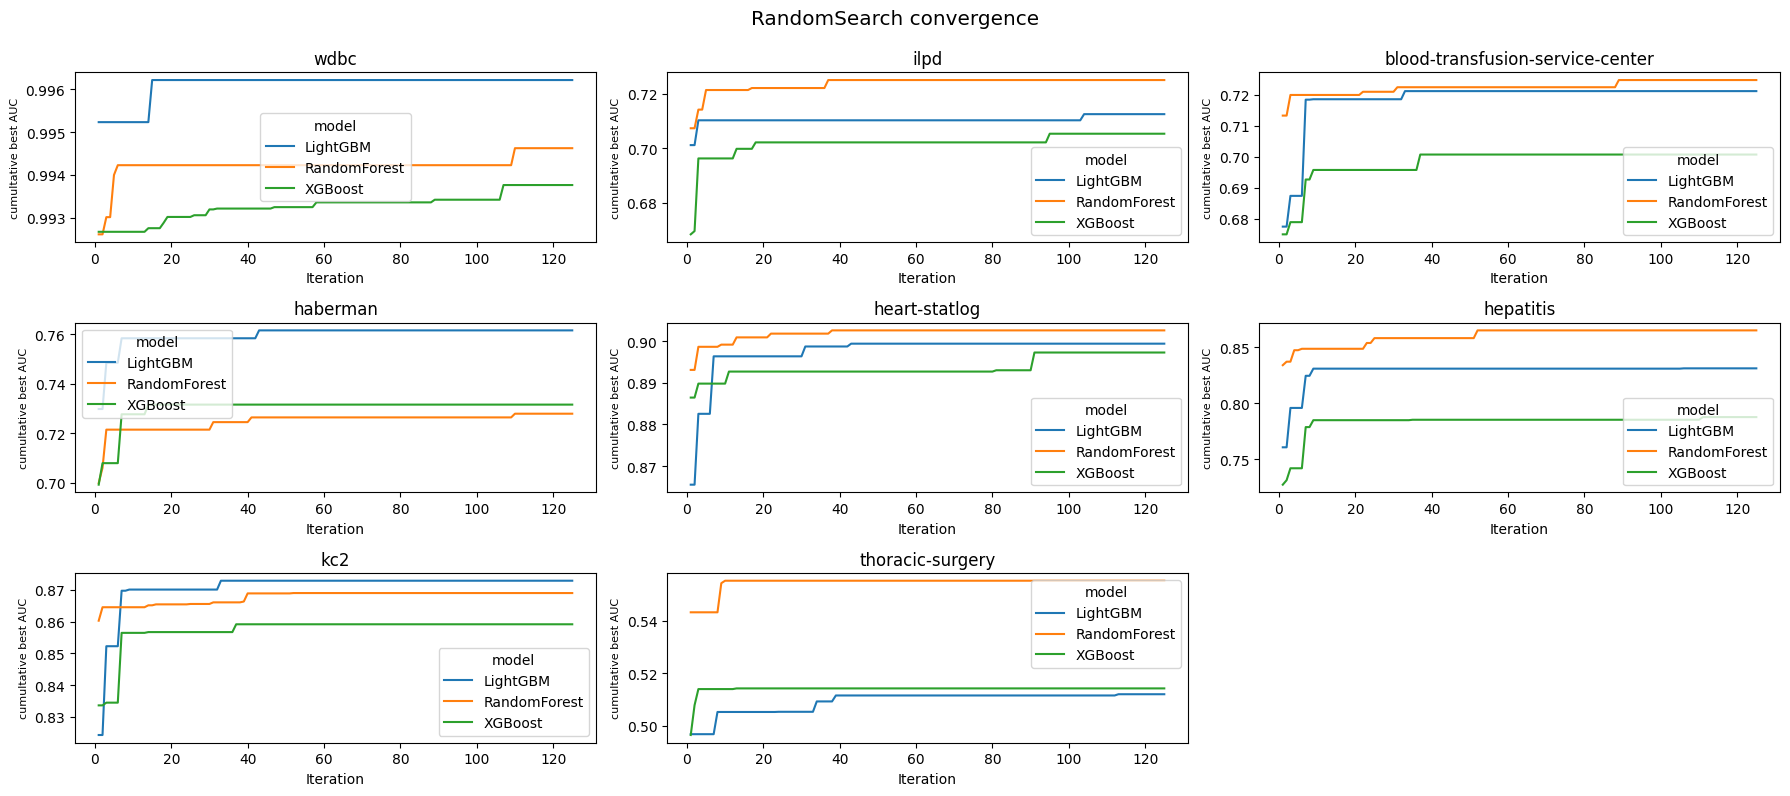

In [131]:
results_df = pd.concat([rf_results_dataframe, xgb_results_dataframe, lgbm_results_dataframe], ignore_index=True)
dataset_names = results_df['dataset'].unique()
stability_plot(results_df, dataset_names, method='RandomSearch')

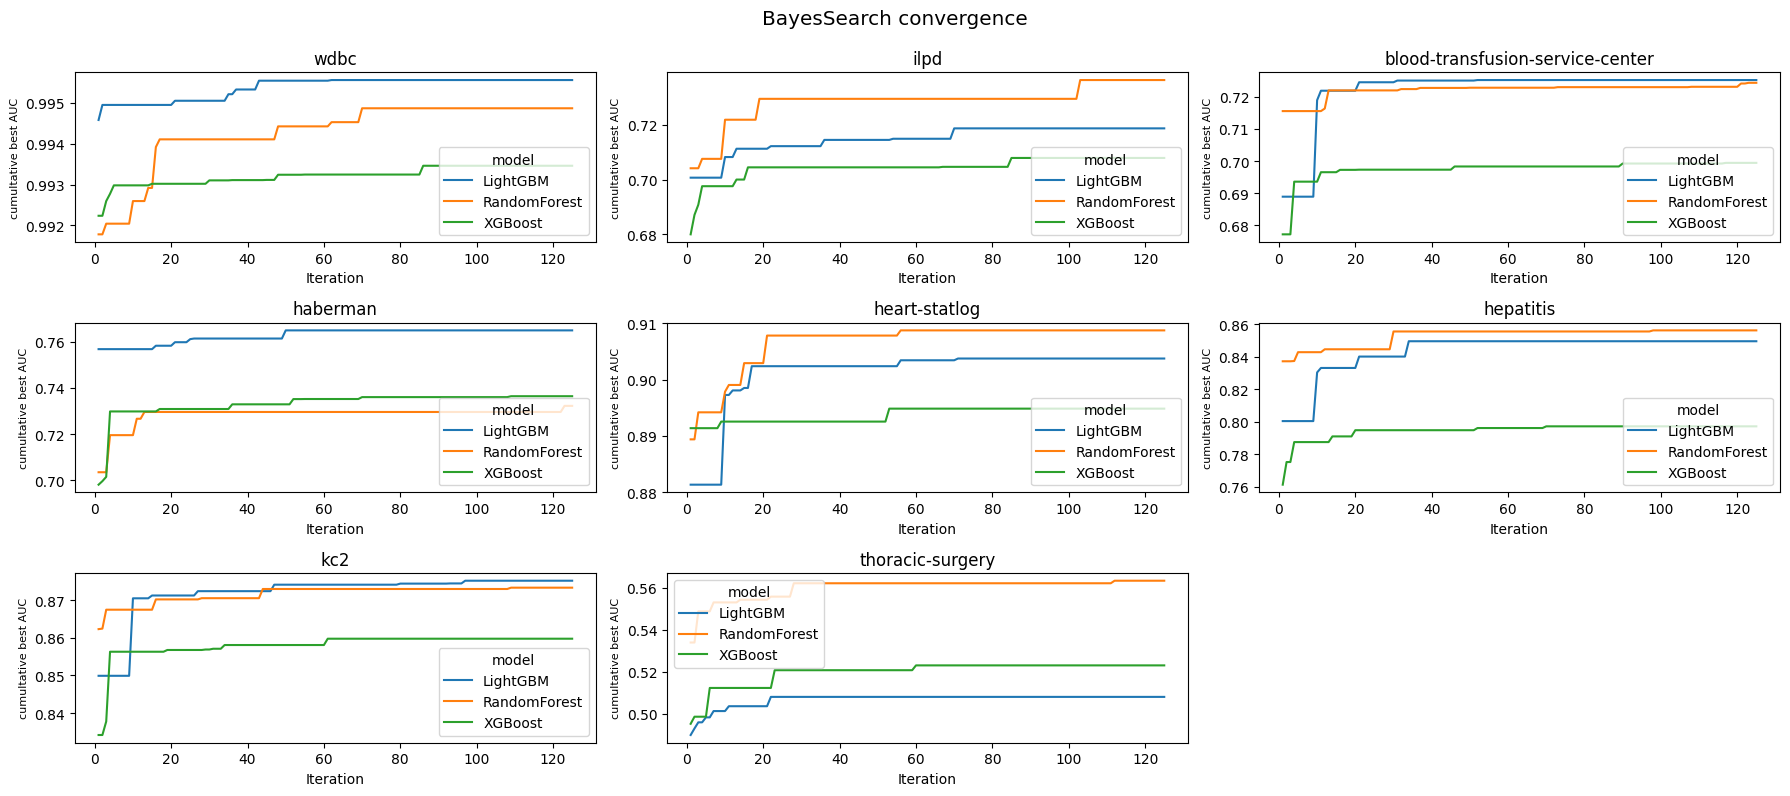

In [132]:
stability_plot(results_df, dataset_names, method='BayesSearch')

### 9. Rozkład różnic pomiędzy miarą otrzymaną dla wcześniej wyznaczonej domyślnej konfiguracji, a miarami uzyskanymi dla innych testowanych konfiguracji

In [133]:
def compute_differences(df, new_default_df, model_name, search_method):
    """
    Oblicza różnice AUC względem domyślnej konfiguracji dla podanej metody wyszukiwania.
    """
    df_method = df[df['search_method'] == search_method].copy()
    df_grid = df[df['search_method'] == 'GridSearch'].copy()

    if search_method in new_default_df['search_method'].values:
        param_cols = [c for c in df_method.columns if c.startswith('model__')]
        default_params = new_default_df[new_default_df['search_method'] == search_method].iloc[0]
        for p in param_cols:
            default_df = df_method[df_method[p] == default_params[p]]
    if search_method == "BayesSearch":
        # dla BayesSearch bierzemy default ustalony za pomocą GridSearch
        param_cols = [c for c in df_grid.columns if c.startswith('model__')]
        default_params = new_default_df[new_default_df['search_method'] == 'GridSearch'].iloc[0]
        for p in param_cols:
            default_df = df_grid[df_grid[p] == default_params[p]]
            
    default_auc = default_df['mean_test_score'].iloc[0]

    # różnica względem domyślnej konfiguracji
    df_method['diff_auc'] = df_method['mean_test_score'] - default_auc
    df_method['model'] = model_name
    return df_method[['dataset', 'model', 'diff_auc']]

In [134]:
def plot_auc_diff_boxplots(all_diff_df, search_method, dataset_names):

    fig, axes = plt.subplots(2, 4, figsize=(18,8))
    axes = axes.flatten()

    for i, dataset_name in enumerate(dataset_names):
        ax = axes[i]
        df_plot = all_diff_df[all_diff_df['dataset'] == dataset_name]

        sns.boxplot(data=df_plot, x='model', y='diff_auc', ax=ax, width=0.6)
        ax.set_title(f'{dataset_name}', fontsize=13)
        ax.set_xlabel('Model')
        ax.set_ylabel('Difference in AUC (vs default)')

    fig.suptitle(f'Distribution of AUC Differences — {search_method}', fontsize=15)
    plt.tight_layout()
    plt.show()

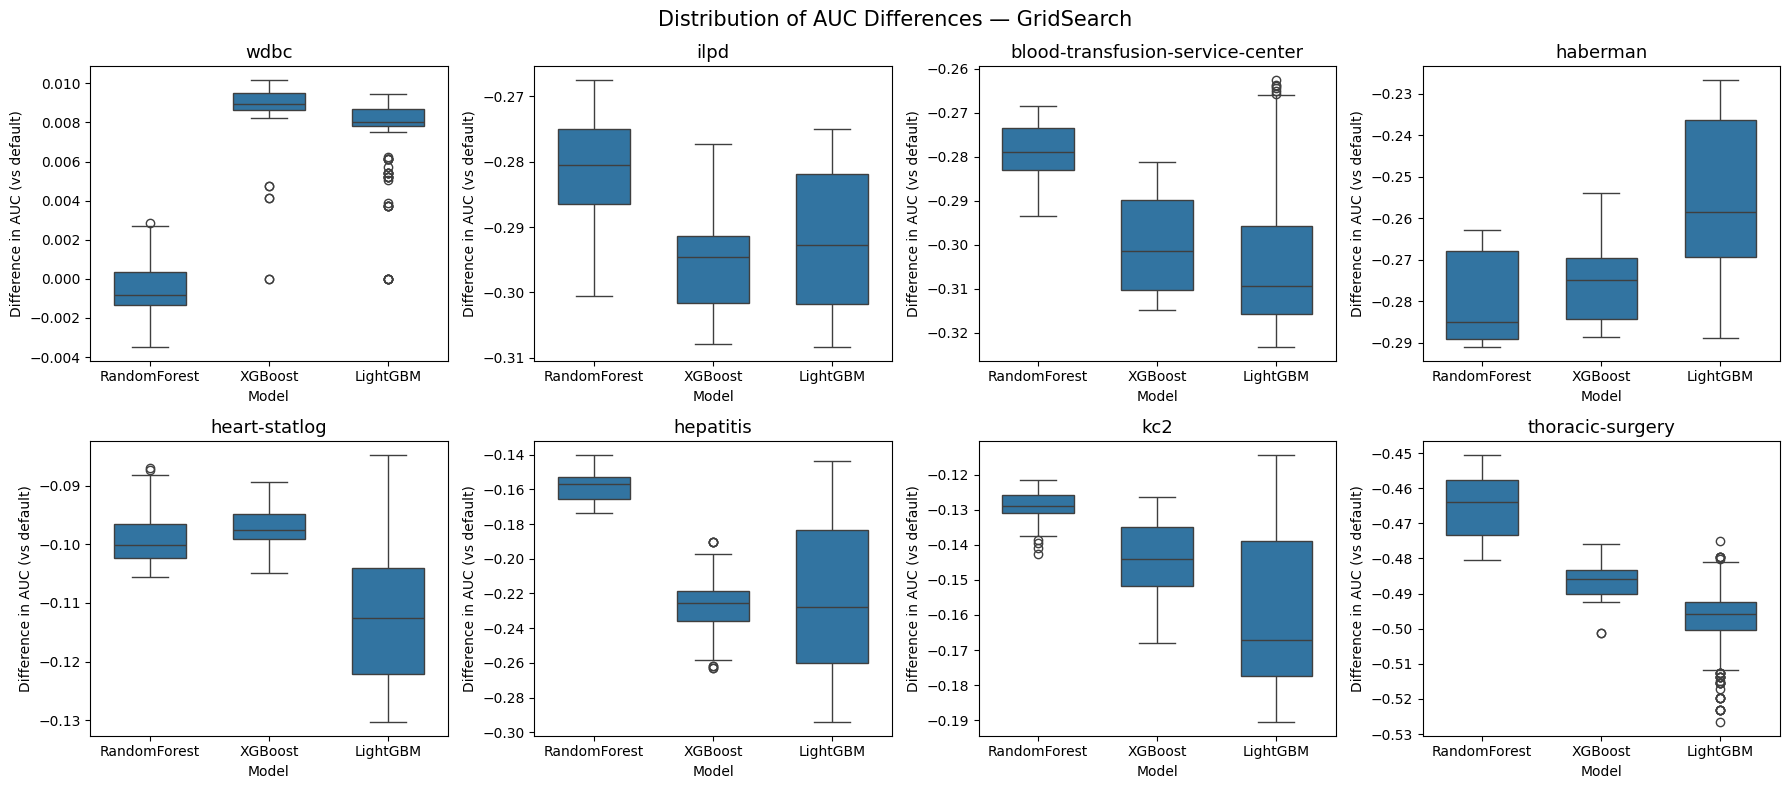

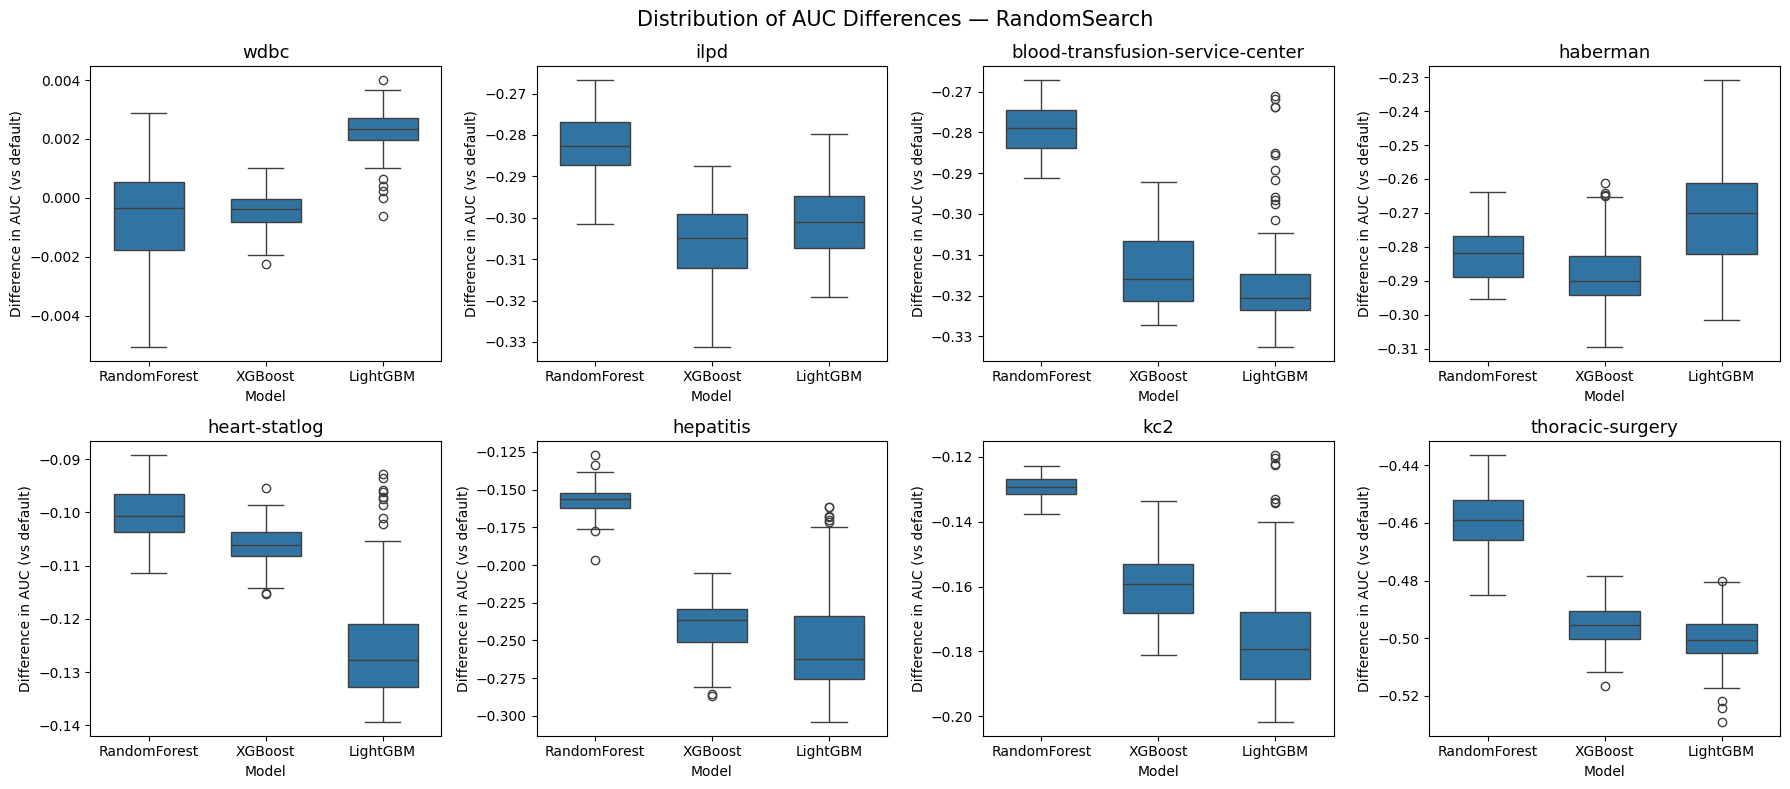

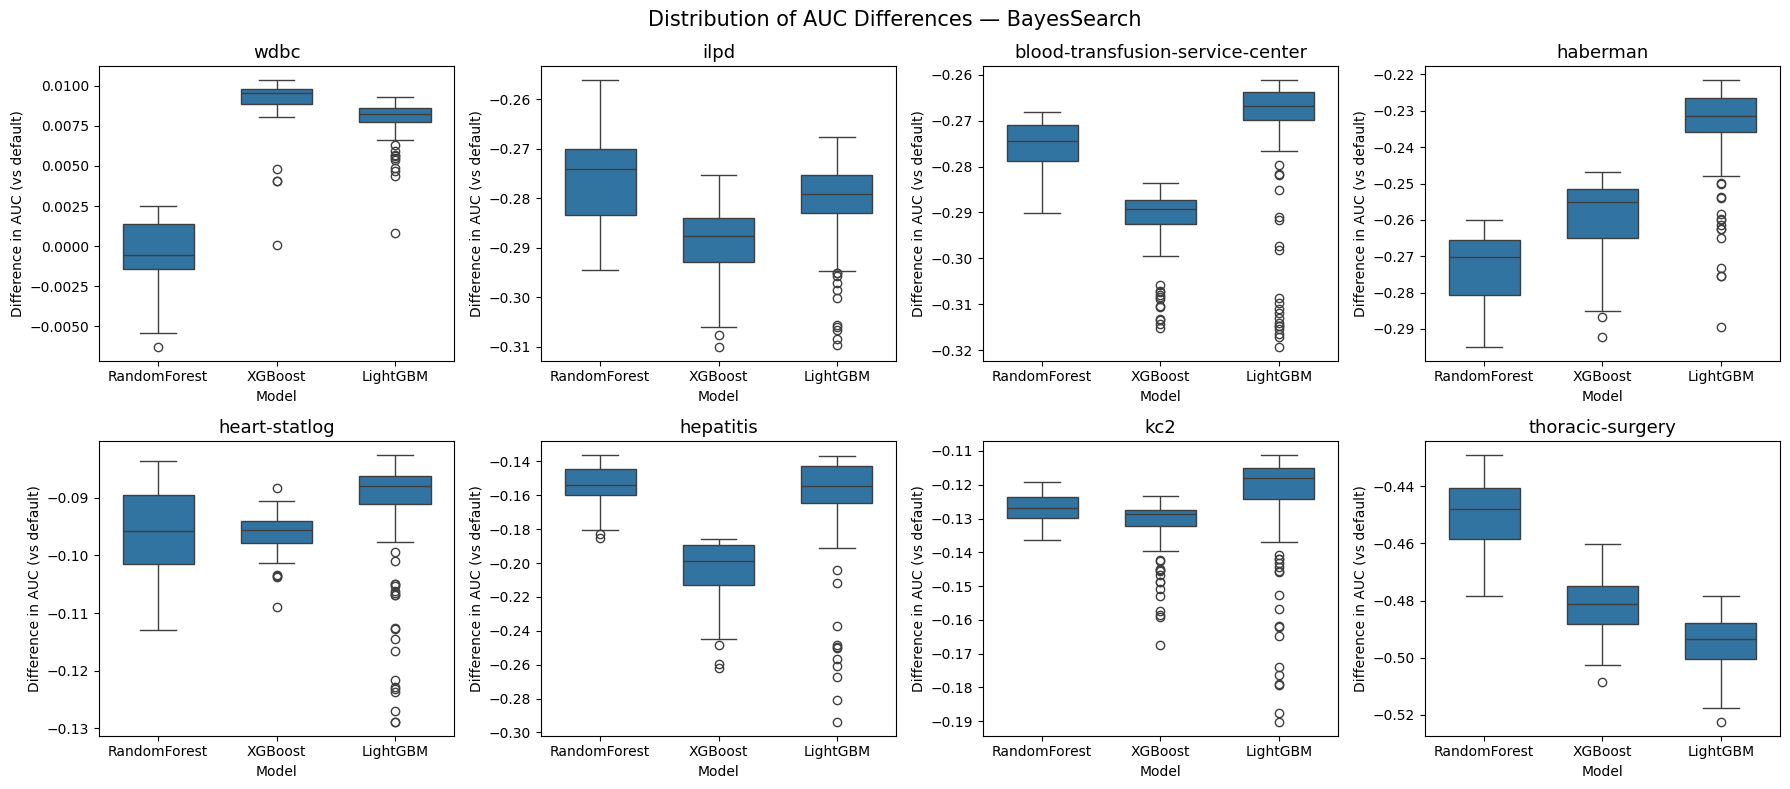

In [135]:
dataset_names = [name for name, _ in datasets]

for i in ['GridSearch', 'RandomSearch', 'BayesSearch']:
    rf_diff = compute_differences(rf_results_dataframe, new_default_params_rf, 'RandomForest', i)
    xgb_diff = compute_differences(xgb_results_dataframe, new_default_params_xgb, 'XGBoost', i)
    lgbm_diff = compute_differences(lgbm_results_dataframe, new_default_params_lgbm, 'LightGBM', i)
    all_diff = pd.concat([rf_diff, xgb_diff, lgbm_diff], ignore_index=True)
    plot_auc_diff_boxplots(all_diff, i, dataset_names)

### 10. Porównanie różnic wyników pomiędzy technikami losowania hiperparametrów

In [136]:
def compute_best_per_dataset(results_df):
    """
    Oblicza najlepszy wynik AUC dla każdego zbioru danych i metody wyszukiwania.
    """
    best_per_dataset = (
        results_df
        .groupby(['dataset', 'search_method'], as_index=False)['mean_test_score']
        .max()
        .rename(columns={'mean_test_score': 'best_auc'})
    )
    return best_per_dataset

In [137]:
rf_results = pd.read_csv('rf_results.csv')
xgb_results = pd.read_csv('xgb_results.csv')       
lgbm_results = pd.read_csv('lgbm_results.csv')
rf_best = compute_best_per_dataset(rf_results)
xgb_best = compute_best_per_dataset(xgb_results)  
lgbm_best = compute_best_per_dataset(lgbm_results)   

In [138]:
def append_default_results(model_best, model_results, new_default_params):
    """
    Dołącza wyniki dla domyślnej konfiguracji hiperparametrów do wyników modelu.
    """
    
    # Jako domyślne wartości hiperparametrów przyjmujemy te znalezione dla GridSearch
    mask = model_results['search_method'] == 'GridSearch'

    for k, v in new_default_params['params'].iloc[0].items():
        if k in model_results.columns:
            mask = mask & (model_results[k] == v)

    result = (
        model_results.loc[mask, ['dataset', 'mean_test_score']]
        .rename(columns={'mean_test_score': 'best_auc'})
    )

    result['search_method'] = 'default'
    return pd.concat([model_best, result], ignore_index=True)

In [139]:
rf_best = append_default_results(rf_best, rf_results, new_default_params_rf)
xgb_best = append_default_results(xgb_best, xgb_results, new_default_params_xgb)  
lgbm_best = append_default_results(lgbm_best, lgbm_results, new_default_params_lgbm)

In [140]:
def compare_sampling_methods(model_best):
    """
    Porównuje metody wyszukiwania hiperparametrów za pomocą testu Friedmana.
    """
    search_method = np.unique(rf_best['search_method'])

    friedman_p_value = friedmanchisquare(*(
                np.array(model_best.loc[model_best['search_method'] == c]['best_auc'])
                for c in search_method))[1]
    return friedman_p_value

In [141]:
print(f"p-value testu Friedmana dla Random Forest: {compare_sampling_methods(rf_best)}")
print(f"p-value testu Friedmana dla XGBoost: {compare_sampling_methods(xgb_best)}")
print(f"p-value testu Friedmana dla LightGBM: {compare_sampling_methods(lgbm_best)}")

p-value testu Friedmana dla Random Forest: 0.28975578119338524
p-value testu Friedmana dla XGBoost: 0.34764264473227524
p-value testu Friedmana dla LightGBM: 0.4153350291627995


### 11. Rozkład tunowalności

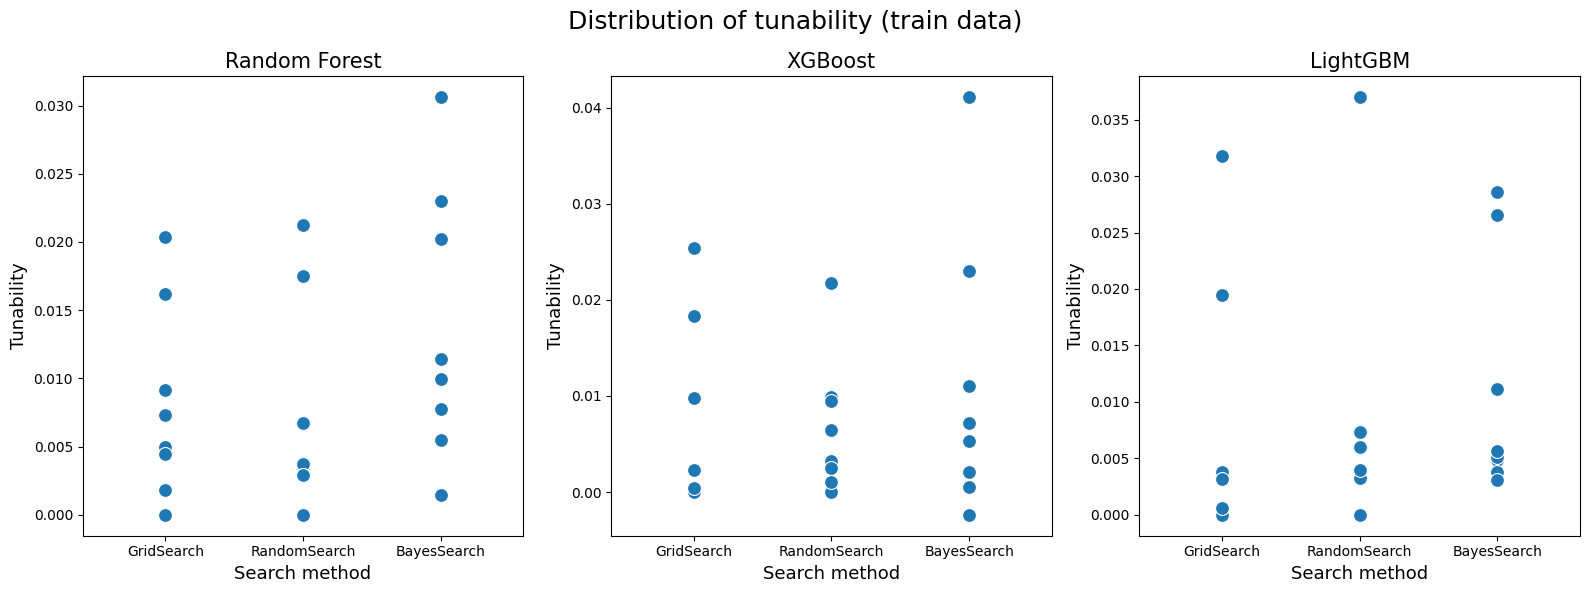

In [142]:
alg_names = ["Random Forest", "XGBoost", "LightGBM"]
fig, axes = plt.subplots(1, 3, figsize=(16,6))
axes = axes.flatten()
tunability_data = [tunability_rf, tunability_xgb, tunability_lgbm]
for i, alg_names in enumerate(alg_names):
    ax = axes[i]
    sns.scatterplot(data=tunability_data[i], y='d_j', x='search_method', ax=ax, s=100)
    ax.set_title(f'{alg_names}', fontsize=15)
    ax.set_ylabel('Tunability', fontsize=13)
    ax.set_xlabel('Search method', fontsize=13)
    ax.margins(x=0.3)

fig.suptitle(f'Distribution of tunability (train data)', fontsize=18)
plt.tight_layout()
plt.show()

In [158]:
tunability_rf_test = pd.concat([rf_test_results_grid, rf_test_results_random, rf_test_results_bayes], ignore_index=True)
tunability_xgb_test = pd.concat([xgb_test_results_grid, xgb_test_results_random, xgb_test_results_bayes], ignore_index=True)
tunability_lgbm_test = pd.concat([lgbm_test_results_grid, lgbm_test_results_random, lgbm_test_results_bayes], ignore_index=True)

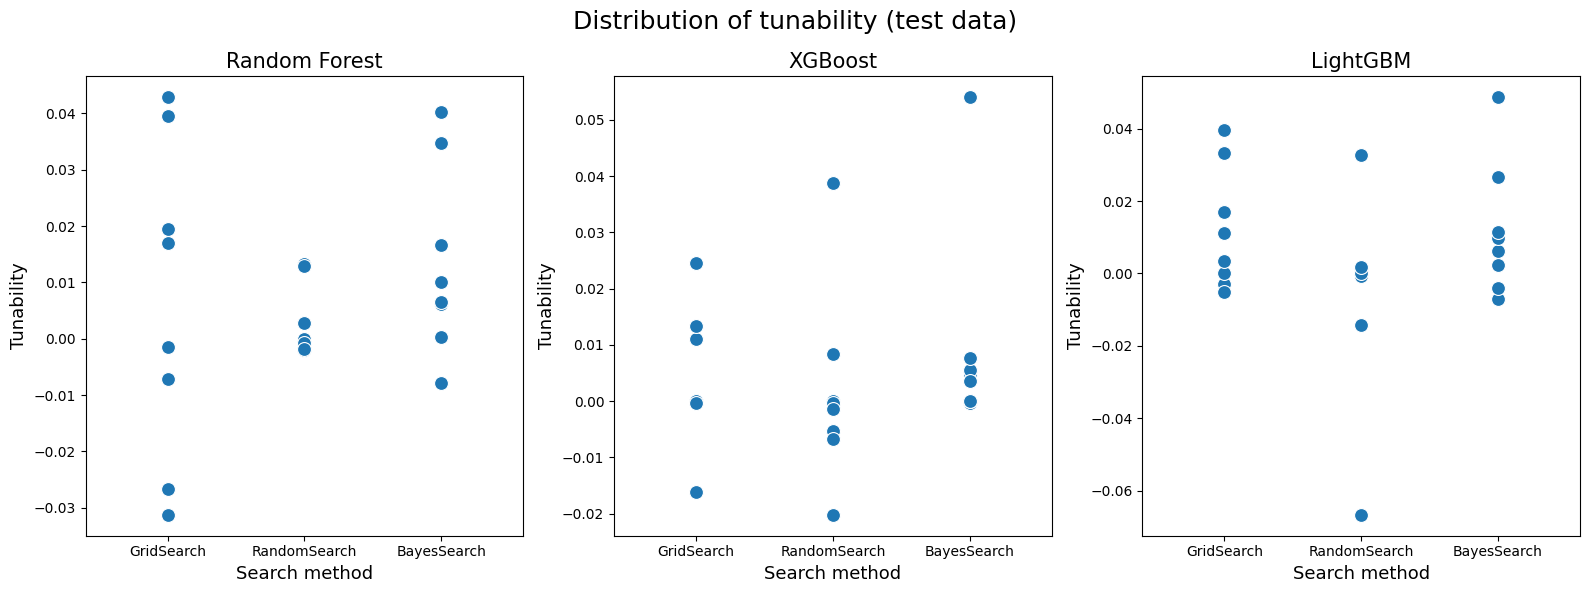

In [159]:
alg_names = ["Random Forest", "XGBoost", "LightGBM"]
fig, axes = plt.subplots(1, 3, figsize=(16,6))
axes = axes.flatten()
tunability_data = [tunability_rf_test, tunability_xgb_test, tunability_lgbm_test]
for i, alg_names in enumerate(alg_names):
    ax = axes[i]
    sns.scatterplot(data=tunability_data[i], y='dj_O', x='search_method', ax=ax, s=100)
    ax.set_title(f'{alg_names}', fontsize=15)
    ax.set_ylabel('Tunability', fontsize=13)
    ax.set_xlabel('Search method', fontsize=13)
    ax.margins(x=0.3)

fig.suptitle(f'Distribution of tunability (test data)', fontsize=18)
plt.tight_layout()
plt.show()

### 12. Wpływ liczności zbioru na tunowalność

In [151]:
def run_sample_size_tunability_for_model(
    pipeline,
    param_grids,
    model_name,
    sample_fracs=(0.75, 0.5)
):
    """
    Funkcja oblicza tunowalność dla różnych wielkości zbiorów danych (75%, 50%, 25%)
    Zwraca ramkę danych:
    ['dataset', 'search_method',
     'tunability_75', 'tunability_50', 'tunability_25']
    """

    tunability_per_frac = {}

    for frac in sample_fracs:
        results_list = []

        for d_name, (X_train, y_train) in datasets:

            X_sub, _, y_sub, _ = train_test_split(
                X_train,
                y_train,
                train_size=frac,
                stratify=y_train,
                random_state=42
            )

            unique, counts = np.unique(y_sub, return_counts=True)
            if len(unique) < 2:
                print(f"Pomijam dataset={d_name}, frac={frac}: tylko jedna klasa w y_sub.")
                continue

            # jeśli klasa mniejszościowa ma mniej obserwacji niż liczba foldów,
            # to w którymś foldzie testowym zabraknie tej klasy
            if counts.min() < 5:
                print(
                    f"Pomijamy dataset={d_name}, frac={frac}: "
                    f"za mało obserwacji klasy mniejszościowej ({counts.min()})."
                )
                continue

            results_df = run_hyperparameter_tuning(
                X_train      = X_sub,
                y_train      = y_sub,
                pipeline     = pipeline,
                param_grids  = param_grids,
                dataset_name = d_name,
                model_name   = model_name
            )

            results_list.append(results_df)

        results_df_frac = pd.concat(results_list, ignore_index=True)

        new_default_params_frac = find_new_default(results_df_frac)

        tunability_frac = compute_tunability(new_default_params_frac, results_df_frac)

        tunability_frac = tunability_frac[['dataset', 'search_method', 'd_j']].copy()

        col_name = f"tunability_{int(frac*100)}"
        tunability_frac.rename(columns={'d_j': col_name}, inplace=True)

        tunability_per_frac[frac] = tunability_frac

    merged = None
    for frac in sample_fracs:
        df_frac = tunability_per_frac[frac]
        if merged is None:
            merged = df_frac
        else:
            merged = merged.merge(
                df_frac,
                on=['dataset', 'search_method'],
                how='inner'
            )

    return merged

In [28]:
sample_tunability_rf = run_sample_size_tunability_for_model(random_forest_pipeline, rf_params, 'RandomForest')

c:\Users\lwysz\anaconda4\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [61]:
tunability_rf_all = tunability_rf.merge(
    sample_tunability_rf,
    on=['dataset', 'search_method'],
    how='inner'
)
tunability_rf_all.rename(columns={'d_j': 'tunability_100'}, inplace=True)

In [62]:
output_filename = 'rf_subset_results.csv'
tunability_rf_all.to_csv(output_filename, index=False)

In [31]:
subset_tunability_xgb = run_sample_size_tunability_for_model(xgboost_pipeline, xgb_params, 'XGBoost')

In [65]:
tunability_xgb_all = tunability_xgb.merge(
    subset_tunability_xgb,
    on=['dataset', 'search_method'],
    how='inner'
)
tunability_xgb_all.rename(columns={'d_j': 'tunability_100'}, inplace=True)

In [67]:
output_filename = 'xgb_subset_results.csv'
tunability_xgb_all.to_csv(output_filename, index=False)

In [ ]:
subset_tunability_lgbm = run_sample_size_tunability_for_model(lightgbm_pipeline, lgbm_params, 'LightGBM')

In [79]:
tunability_lgbm_all = tunability_lgbm.merge(
    subset_tunability_lgbm,
    on=['dataset', 'search_method'],
    how='inner'
)
tunability_lgbm_all.rename(columns={'d_j': 'tunability_100'}, inplace=True)

In [80]:
output_filename = 'lgbm_subset_results.csv'
tunability_lgbm_all.to_csv(output_filename, index=False)

In [72]:
def plot_tunability_vs_sample_size(tunability_df, model):

    datasets_order = sorted(tunability_df['dataset'].unique())
    dataset_to_idx = {name: i for i, name in enumerate(datasets_order)}

    tunability_df = tunability_df.copy()
    tunability_df['dataset_id'] = tunability_df['dataset'].map(dataset_to_idx)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    methods = ['RandomSearch', 'GridSearch']

    for ax, method in zip(axes, methods):
        df_m = tunability_df[tunability_df['search_method'] == method]

        ax.scatter(df_m['dataset_id'], df_m['tunability_100'], label='100% danych')
        ax.scatter(df_m['dataset_id'], df_m['tunability_75'],  label='75% danych')
        ax.scatter(df_m['dataset_id'], df_m['tunability_50'],  label='50% danych')

        ax.set_title(method)
        ax.set_xlabel('Numer zbioru danych')
        ax.grid(True, alpha=0.3)

    axes[0].set_ylabel('Tunowalność')
    axes[0].legend(title='Rozmiar zbioru danych')

    fig.suptitle(model)
    plt.tight_layout()
    plt.show()

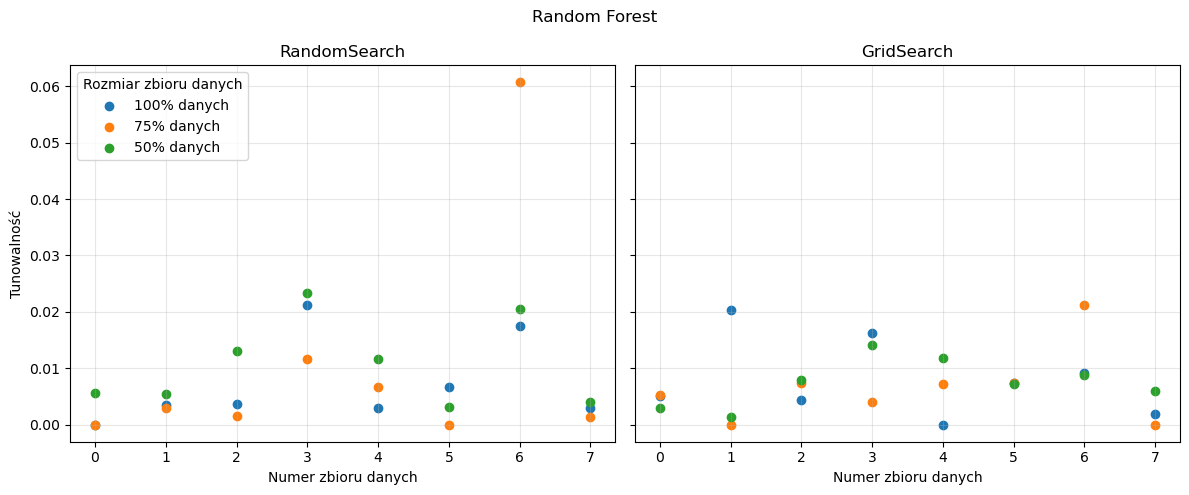

In [73]:
plot_tunability_vs_sample_size(tunability_rf_all, 'Random Forest')

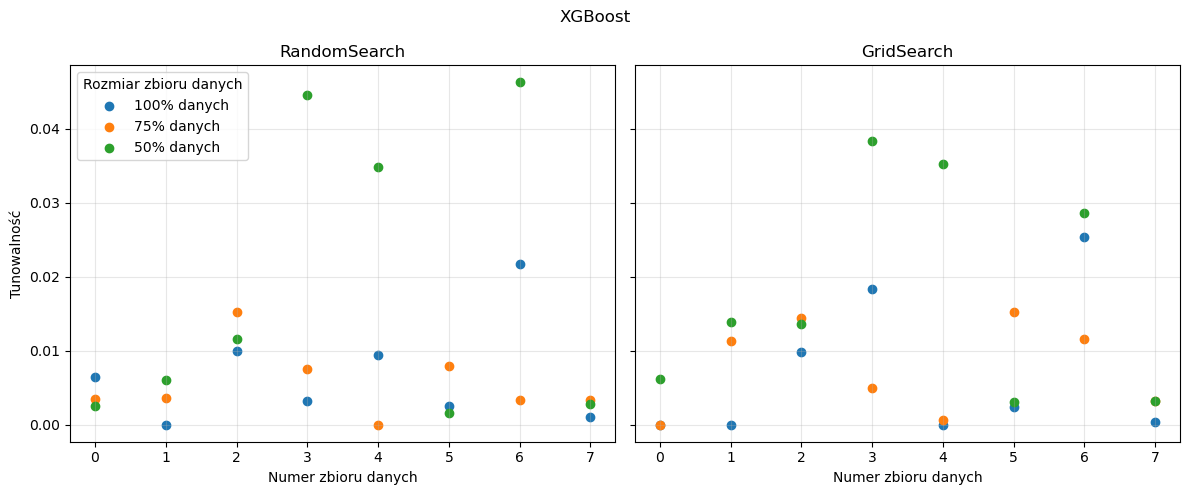

In [74]:
plot_tunability_vs_sample_size(tunability_xgb_all, 'XGBoost')

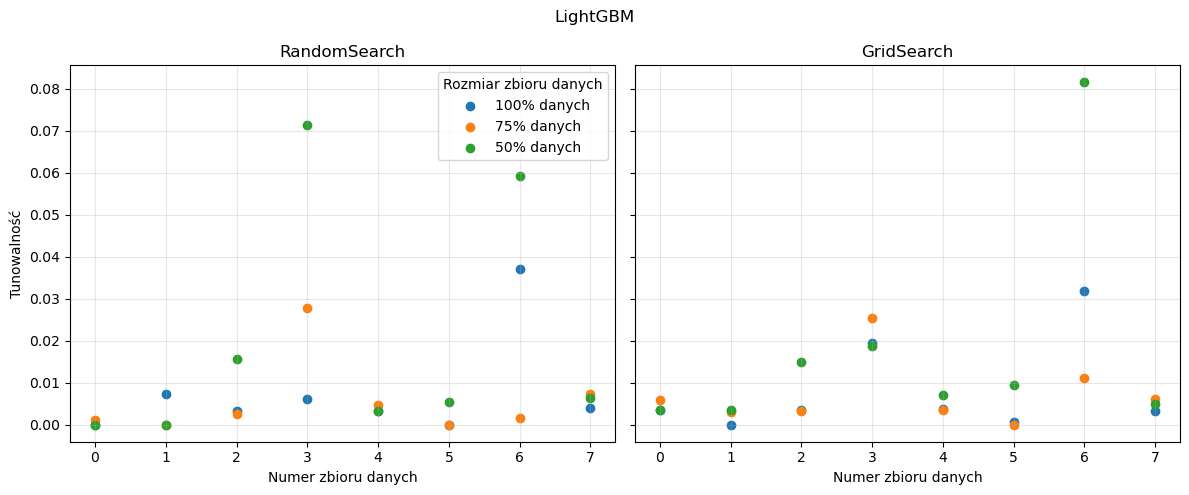

In [81]:
plot_tunability_vs_sample_size(tunability_lgbm_all, 'LightGBM')